# **The Smell of Polymers: Prediction of Molecular Odor Characteristics by Deep Learning Models**

## Research Project 1
## Group 14
#### Christos Koromilas, Stephan Possen, Mireia Fortuño Ledesma, Lázár Dávid Barta, Mathias Verschueren

## January 2024

# 1. Installs and imports

In [1]:
!pip install --upgrade -q rdkit py3Dmol
!pip install scikit-learn
!pip install scikit-multilearn
!pip install keras-tuner --upgrade
!pip install molgraph


In [2]:
# rdkit library
from rdkit import Chem
from rdkit.Chem import Draw, Descriptors, AllChem

# 3Dmodel
import py3Dmol

# Standard libraries
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Google Colab libraries
from google.colab import drive, files

# scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import jaccard_score, hamming_loss, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils.class_weight import compute_class_weight

# Binary relevance imports
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from skmultilearn.problem_transform import BinaryRelevance

# NN imports
import keras_tuner as kt
import tensorflow as tf
import keras
from keras.layers import Dense
from keras import Sequential
from keras import callbacks
from keras.metrics import Precision, Recall, CategoricalAccuracy

# GNN imports
from tensorflow import keras
from molgraph import chemistry
from molgraph import layers
from molgraph import models
from rdkit import Chem


# 2. Mount drive and read files

To be able to mount the Drive, you need to link the Group 14 folder to your drive "My Drive".

Instructions:
- Go to "Shared with Me"
- Find the "Group 14" folder
- Right click on the folder
- Click "organise" --> "Add Shortcut"

Now the Group 14 folder has been added to "My Drive" and you should be able to mount the drive with the following code.

In [3]:
drive.mount(
    "/content/drive"
    , force_remount=True
    )
# Our Directory
main_directory_path = "./drive/MyDrive/Group14/Code/Dataset/"

Mounted at /content/drive


In [4]:
dataset_ex = ""
datasets = [f for f in os.listdir(main_directory_path) if f.endswith(".csv") and f not in dataset_ex]
print(len(datasets))
print(datasets)

4
['smiles_descriptors_binary_multi.csv', 'smiles_descriptors_processed_minmax_binary_multi.csv', 'smiles_descriptors_fingerprints_fused_binary_multi.csv', 'smiles_fingerprints_binary_multi.csv']


In [5]:
for dataset in datasets:
  df = pd.read_csv(main_directory_path + dataset)
  print(dataset)
  print(len(df.columns))
  print(df.columns)
  print("--------------------------------------")

smiles_descriptors_binary_multi.csv
215
Index(['SMILES', 'SENTENCE', 'binary', 'multi', 'MaxAbsEStateIndex',
       'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS',
       ...
       'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole',
       'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane',
       'fr_urea', 'SPS.1'],
      dtype='object', length=215)
--------------------------------------
smiles_descriptors_processed_minmax_binary_multi.csv
193
Index(['SMILES', 'SENTENCE', 'binary', 'multi', 'MaxAbsEStateIndex',
       'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS',
       ...
       'fr_priamide', 'fr_pyridine', 'fr_quatN', 'fr_sulfide',
       'fr_term_acetylene', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
       'fr_unbrch_alkane', 'SPS.1'],
      dtype='object', length=193)
--------------------------------------
smiles_descriptors_fingerprints_fused_binary_multi.csv
2241
Index(['SMILES', 'SENTENCE', 'bi

## Descriptors Data

In [6]:
df_descriptors = pd.read_csv(main_directory_path + "smiles_descriptors_processed_minmax_binary_multi.csv")
print(df_descriptors.head())
print("\nShape: ", df_descriptors.shape)

                             SMILES                   SENTENCE  binary  \
0       C/C=C/C(=O)C1CCC(C=C1C)(C)C                fruity,rose       0   
1                         COC(=O)OC      ethereal,fruity,fresh       0   
2               Cc1cc2c([nH]1)cccc2          animalic,resinous       0   
3            C1CCCCCCCC(=O)CCCCCCC1      musk,powdery,animalic       0   
4  CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C  fruity,coniferous,camphor       0   

                                               multi  MaxAbsEStateIndex  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.791339   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.658966   
2  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...           0.220539   
3  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...           0.783479   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.799792   

   MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed       SPS  ...  \
0        0.791339      

## Fingerprints Data

In [7]:
df_fingerprints = pd.read_csv(main_directory_path + "smiles_fingerprints_binary_multi.csv")
print(df_fingerprints.head())
print("\nShape: ", df_fingerprints.shape)

                             SMILES                   SENTENCE  binary  \
0       C/C=C/C(=O)C1CCC(C=C1C)(C)C                fruity,rose       0   
1                         COC(=O)OC      ethereal,fruity,fresh       0   
2               Cc1cc2c([nH]1)cccc2          animalic,resinous       0   
3            C1CCCCCCCC(=O)CCCCCCC1      musk,powdery,animalic       0   
4  CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C  fruity,coniferous,camphor       0   

                                               multi  Morgan_FP_0  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...            0   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...            0   
2  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...            0   
3  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...            0   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...            0   

   Morgan_FP_1  Morgan_FP_2  Morgan_FP_3  Morgan_FP_4  Morgan_FP_5  ...  \
0            0            0            0            0            

## Descriptors and Fingerprints together

In [8]:
df_fused = pd.read_csv(main_directory_path + "smiles_descriptors_fingerprints_fused_binary_multi.csv")
print(df_fused.head())
print("\nShape: ", df_fused.shape)

                             SMILES                   SENTENCE  binary  \
0       C/C=C/C(=O)C1CCC(C=C1C)(C)C                fruity,rose       0   
1                         COC(=O)OC      ethereal,fruity,fresh       0   
2               Cc1cc2c([nH]1)cccc2          animalic,resinous       0   
3            C1CCCCCCCC(=O)CCCCCCC1      musk,powdery,animalic       0   
4  CC(CC(=O)OC1CC2C(C1(C)CC2)(C)C)C  fruity,coniferous,camphor       0   

                                               multi  MaxAbsEStateIndex  \
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.791339   
1  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.658966   
2  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...           0.220539   
3  [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ...           0.783479   
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...           0.799792   

   MaxEStateIndex  MinAbsEStateIndex  MinEStateIndex       qed       SPS  ...  \
0        0.791339      

# 3. Data checks

In [9]:
def check_duplicates(sentence):
    classes = sentence.split(',')
    return len(classes) != len(set(classes))

duplicates_filter = df_descriptors['SENTENCE'].apply(check_duplicates)
print(len(df_descriptors[duplicates_filter]))

duplicates_filter = df_fingerprints['SENTENCE'].apply(check_duplicates)
print(len(df_fingerprints[duplicates_filter]))

duplicates_filter = df_fused['SENTENCE'].apply(check_duplicates)
print(len(df_fused[duplicates_filter]))

0
0
0


In [10]:
all_smells_1 = df_descriptors['SENTENCE'].str.split(',').sum()
unique_smells_1 = np.unique(all_smells_1)

all_smells_2 = df_fingerprints['SENTENCE'].str.split(',').sum()
unique_smells_2 = np.unique(all_smells_2)

all_smells_3 = df_fused['SENTENCE'].str.split(',').sum()
unique_smells_3 = np.unique(all_smells_3)

print(all_smells_1==all_smells_2==all_smells_3)
print(np.array_equal(unique_smells_1, unique_smells_2) and np.array_equal(unique_smells_1, unique_smells_3))

print(len(unique_smells_1))
print(unique_smells_1)

True
True
109
['alcoholic' 'aldehydic' 'alliaceous' 'almond' 'ambergris' 'ambery'
 'ambrette' 'ammoniac' 'animalic' 'anisic' 'apple' 'balsamic' 'banana'
 'berry' 'blackcurrant' 'blueberry' 'body' 'bread' 'burnt' 'butter'
 'cacao' 'camphor' 'caramellic' 'cedar' 'cheese' 'chemical' 'cherry'
 'cinnamon' 'citrus' 'clean' 'clove' 'coconut' 'coffee' 'cognac'
 'coniferous' 'cooked' 'cooling' 'cucumber' 'dairy' 'dry' 'earthy' 'ester'
 'ethereal' 'fatty' 'fennel' 'fermented' 'floral' 'fresh' 'fruity'
 'geranium' 'gourmand' 'grape' 'grapefruit' 'grass' 'green' 'herbal'
 'honey' 'hyacinth' 'jasmin' 'lactonic' 'leaf' 'leather' 'lemon' 'lily'
 'liquor' 'meat' 'medicinal' 'melon' 'metallic' 'mint' 'mushroom' 'musk'
 'musty' 'nut' 'odorless' 'oily' 'orange' 'overripe' 'pear' 'pepper'
 'phenolic' 'plastic' 'plum' 'powdery' 'pungent' 'rancid' 'resinous'
 'ripe' 'roasted' 'rose' 'seafood' 'sharp' 'smoky' 'sour' 'spicy'
 'sulfuric' 'sweet' 'syrup' 'terpenic' 'tobacco' 'tropicalfruit' 'vanilla'
 'vegetabl

In [11]:
print(len(df_descriptors.columns))
print(df_descriptors.columns)

print(len(df_fingerprints.columns))
print(df_fingerprints.columns)

print(len(df_fused.columns))
print(df_fused.columns)

193
Index(['SMILES', 'SENTENCE', 'binary', 'multi', 'MaxAbsEStateIndex',
       'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS',
       ...
       'fr_priamide', 'fr_pyridine', 'fr_quatN', 'fr_sulfide',
       'fr_term_acetylene', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
       'fr_unbrch_alkane', 'SPS.1'],
      dtype='object', length=193)
2052
Index(['SMILES', 'SENTENCE', 'binary', 'multi', 'Morgan_FP_0', 'Morgan_FP_1',
       'Morgan_FP_2', 'Morgan_FP_3', 'Morgan_FP_4', 'Morgan_FP_5',
       ...
       'Morgan_FP_2038', 'Morgan_FP_2039', 'Morgan_FP_2040', 'Morgan_FP_2041',
       'Morgan_FP_2042', 'Morgan_FP_2043', 'Morgan_FP_2044', 'Morgan_FP_2045',
       'Morgan_FP_2046', 'Morgan_FP_2047'],
      dtype='object', length=2052)
2241
Index(['SMILES', 'SENTENCE', 'binary', 'multi', 'MaxAbsEStateIndex',
       'MaxEStateIndex', 'MinAbsEStateIndex', 'MinEStateIndex', 'qed', 'SPS',
       ...
       'Morgan_FP_990', 'Morgan_FP_991', 'Morgan_FP_992', 'Morgan_FP_

# 4. Data Split for Models

Use df_fused bc it has both data
* GNN model only needs SMILES as feature
* BR and NN models need DESCRIPTORS and FINGERPRINTS as features:
  * first 4 columns not to be used: 'SMILES', 'SENTENCE', 'binary', 'multi'
  * columns Descriptors --> 4:193 (in X --> 0:189)
  * columns Fingerprints --> 193: 2241 (in X --> 189:2237)
* All models use the same target variable

In [12]:
# Initialize the MultiLabel Binarizer
target = df_fused['SENTENCE'].str.split(',')
mlb = MultiLabelBinarizer()
mlb.fit(target)

MultiLabelBinarizer()

In [13]:
# Split the data into train and test sets
train_df, temp_df = train_test_split(df_fused, test_size=0.2, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size = 0.5, random_state=42)

print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(3452, 2241)
(432, 2241)
(432, 2241)


In [14]:
# Create features and targets for the models

# TARGET: binarized target variable of train, validation and test
# all 5 models use the same target variable
y_train = mlb.transform(train_df['SENTENCE'].str.split(','))
y_val = mlb.transform(val_df['SENTENCE'].str.split(','))
y_test = mlb.transform(test_df['SENTENCE'].str.split(','))
print("y_train:", y_train.shape, ", y_val:", y_val.shape, ", y_test:", y_test.shape)


# FEATURES

# for GNN model
SMILES_train = train_df["SMILES"].tolist()
SMILES_val = val_df["SMILES"].tolist()
SMILES_test = test_df["SMILES"].tolist()

# for NN and BR models
X_train = train_df.iloc[:, 4:2241].values
X_train_descr = X_train[:, 0:189]
X_train_finger = X_train[:, 189:2237]
print("X_train:", X_train.shape, ", X_train_descr:", X_train_descr.shape, ", X_train_finger:", X_train_finger.shape)

X_val = val_df.iloc[:, 4:2241].values
X_val_descr = X_val[:, 0:189]
X_val_finger = X_val[:, 189:2237]
print("X_val:", X_val.shape, ", X_val_descr:", X_val_descr.shape, ", X_val_finger:", X_val_finger.shape)

X_test = test_df.iloc[:, 4:2241].values
X_test_descr = X_test[:, 0:189]
X_test_finger = X_test[:, 189:2237]
print("X_test:", X_test.shape, ", X_test_descr:", X_test_descr.shape, ", X_test_finger:", X_test_finger.shape)

y_train: (3452, 109) , y_val: (432, 109) , y_test: (432, 109)
X_train: (3452, 2237) , X_train_descr: (3452, 189) , X_train_finger: (3452, 2048)
X_val: (432, 2237) , X_val_descr: (432, 189) , X_val_finger: (432, 2048)
X_test: (432, 2237) , X_test_descr: (432, 189) , X_test_finger: (432, 2048)


# 5. Model 1: Binary Relevance

In [15]:
class BinaryRelevanceModel:
    def __init__(self, scale_pos_weight, mlb):
        self.scale_pos_weight = scale_pos_weight
        self.mlb = mlb

    def build_model(self, X_train, y_train):
        # Create the XGBClassifier with scale_pos_weight
        classifier = XGBClassifier(scale_pos_weight=self.scale_pos_weight)
        # Train the BinaryRelevance classifier
        self.br_classifier = BinaryRelevance(classifier, require_dense=[False, True])
        self.br_classifier.fit(X_train, y_train)

    def predict(self, X_test):
        # Predicted probabilities for each smell
        self.prediction_probs = self.br_classifier.predict_proba(X_test)
        # Get rankings and predictions from the probabilities
        self.predict_and_rank_from_probabilities()
        self.recover_labels_from_rankings()

    def evaluate(self, y_true):
        y_predicted = self.predictions_from_probs
        # Compute metrics
        accuracy = accuracy_score(y_true, y_predicted)
        precision = precision_score(y_true, y_predicted, average='samples')
        recall = recall_score(y_true, y_predicted, average='samples')
        f1 = f1_score(y_true, y_predicted, average='samples')
        jaccard = jaccard_score(y_true, y_predicted, average='samples')
        hamming = hamming_loss(y_true, y_predicted)

        print("Evaluation Metrics:")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1-score: {f1:.2f}")
        print(f"Jaccard Score: {jaccard:.2f}")
        print(f"Hamming Loss: {hamming:.2f}")

    def predict_and_rank_from_probabilities(self):
        # Convert to dense format if it's a sparse matrix
        dense_prediction_probs = self.prediction_probs.toarray()
        num_rows = dense_prediction_probs.shape[0]

        # Array with 3 on the highest prob smell, 2 on the 2nd, 1 on the 3rd, 0 otherwise
        rankings = np.zeros_like(dense_prediction_probs, dtype=int)

        # Compute the rankings
        for i in range(num_rows):
            order = np.argsort(dense_prediction_probs[i])  # Sorts the probabilities
            # Get the indeces of the highest probabilities (the last 3 positions)
            top_3_indeces = order[-3:]
            # Put 3 to the highest probability position, 2 to the 2nd, 1 to the 3rd
            for j in [3,2,1]:
              index_j = top_3_indeces[j-1]
              rankings[i][index_j] = j

        # Binary array with 1 on the top 3 smells
        predictions_from_probs = np.where(rankings != 0, 1, 0)

        # Store results in class variables
        self.rankings = rankings
        self.predictions_from_probs = predictions_from_probs

    def recover_labels_from_rankings(self):

        # Store recovered labels here
        recovered_labels = []

        # Loop through the samples
        for i in range(self.rankings.shape[0]):
          recovered_labels_i = []
          # Find the 3 cases where rank is not 0 (top 3 smells)
          for j in [3,2,1]:
            # Create new binary vector where only one of the smells is 1
            binarized_label = np.zeros_like(self.rankings[i], dtype=int)
            index = np.where(self.rankings[i] == j)
            binarized_label[index] = 1

            # Recover the original label of that top ranked smell from binary
            recovered_label = self.mlb.inverse_transform(np.array([binarized_label]))
            recovered_labels_i.append(recovered_label[0][0])

          recovered_labels.append(recovered_labels_i)

        # Store results in class variables
        self.recovered_labels = recovered_labels


In [16]:
y = mlb.transform(target)
# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y), y=y.ravel())

# Calculate scale_pos_weight for classifier models
# ratio of negative class weight to positive class weight
scale_pos_weight = class_weights[1] / class_weights[0]

## BR + DESCRIPTORS

In [17]:
DESCR_br_model = BinaryRelevanceModel(scale_pos_weight, mlb)
DESCR_br_model.build_model(X_train_descr, y_train)
DESCR_br_model.predict(X_val_descr)
DESCR_br_model.evaluate(y_val)

Evaluation Metrics:
Accuracy: 0.01
Precision: 0.31
Recall: 0.35
F1-score: 0.31
Jaccard Score: 0.21
Hamming Loss: 0.04


In [18]:
# Add recovered_labels to df_val
val_df['BR_DESCRIPTORS_labels'] = DESCR_br_model.recovered_labels

# See results of descriptors
val_df[['SMILES', 'SENTENCE', 'BR_DESCRIPTORS_labels']]

,SMILES,SENTENCE,BR_DESCRIPTORS_labels
4230,CCCCCCCCCC(C)C(OC)OC,"lemon,ambery,aldehydic,green,waxy","[oily, ambery, woody]"
1253,CCCCCCC1C(C)CC(=O)O1,"fruity,floral,lactonic,tropicalfruit,green,butter","[fruity, metallic, floral]"
1905,CCCCC(CC)COC(=O)CC,"pear,wine,grape","[herbal, floral, fruity]"
893,CC(=CCOCCc1ccccc1)C,"herbal,geranium,spicy","[fruity, floral, metallic]"
2879,CC/C=C(\C)/COC(=O)C,"pear,melon,banana","[banana, fruity, green]"
...,...,...,...
2706,CCCC/C=C/C(=O)C,"mushroom,dairy","[grass, mushroom, fruity]"
270,O=C(Cc1ccccc1)OCC1CCCO1,"honey,resinous","[honey, cacao, floral]"
3827,c1ccc2cnccc2c1,"almond,sweet,balsamic,anisic","[tobacco, floral, chemical]"
1926,COC1CCc2ccccc12,"animalic,mint,sweet,floral,anisic,earthy","[floral, woody, camphor]"


In [19]:
# predict and evaluate for the test data now, using the trained model
DESCR_br_model.predict(X_test_descr)
DESCR_br_model.evaluate(y_test)

test_df['BR_DESCRIPTORS_labels'] = DESCR_br_model.recovered_labels
test_df[['SMILES', 'SENTENCE', 'BR_DESCRIPTORS_labels']]

Evaluation Metrics:
Accuracy: 0.01
Precision: 0.29
Recall: 0.34
F1-score: 0.29
Jaccard Score: 0.21
Hamming Loss: 0.04


,SMILES,SENTENCE,BR_DESCRIPTORS_labels
1483,CC(=CCCC(C)CCOC(=O)c1ccccc1)C,"dry,herbal,rose","[balsamic, floral, green]"
3591,CCCCCCC1(C)OCC(CO1)(C)C,"fruity,herbal,fresh","[herbal, fruity, floral]"
1017,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1OC(=O)C,"fruity,mint,herbal,floral,green","[fruity, mint, cooling]"
2016,O=C/C=C/c1ccc(c(c1)OC)O,vanilla,"[vanilla, spicy, fruity]"
2495,CC1(C)[C@@H]2CC[C@@](C)(C2)[C@@H]1O,"clean,cooling,camphor,green,resinous","[camphor, resinous, woody]"
...,...,...,...
2997,OCCC1CCCCC1,"fermented,floral,oily,fresh","[lily, cooling, waxy]"
4176,CCCC(=O)OC/C=C(\CCC=C(C)C)/C,"citrus,floral,fatty,fresh","[waxy, green, apple]"
305,OCCOc1ccc(cc1N)N.Cl.Cl,odorless,"[balsamic, sweet, almond]"
2887,Cc1cc(C)c(cc1C)C,"chemical,roasted,camphor","[camphor, roasted, chemical]"


## BR + FINGERPRINTS

In [20]:
FINGER_br_model = BinaryRelevanceModel(scale_pos_weight, mlb)
FINGER_br_model.build_model(X_train_finger, y_train)
FINGER_br_model.predict(X_val_finger)
FINGER_br_model.evaluate(y_val)

Evaluation Metrics:
Accuracy: 0.01
Precision: 0.30
Recall: 0.33
F1-score: 0.30
Jaccard Score: 0.21
Hamming Loss: 0.04


In [21]:
# Add your y_val and recovered_labels to df_val
val_df['BR_FINGERPRINTS_labels'] = FINGER_br_model.recovered_labels

# See results of descriptors AND Fingerprints
val_df[['SMILES', 'SENTENCE', 'BR_DESCRIPTORS_labels', 'BR_FINGERPRINTS_labels']]

,SMILES,SENTENCE,BR_DESCRIPTORS_labels,BR_FINGERPRINTS_labels
4230,CCCCCCCCCC(C)C(OC)OC,"lemon,ambery,aldehydic,green,waxy","[oily, ambery, woody]","[ambery, floral, citrus]"
1253,CCCCCCC1C(C)CC(=O)O1,"fruity,floral,lactonic,tropicalfruit,green,butter","[fruity, metallic, floral]","[fruity, plum, metallic]"
1905,CCCCC(CC)COC(=O)CC,"pear,wine,grape","[herbal, floral, fruity]","[wine, sweet, fruity]"
893,CC(=CCOCCc1ccccc1)C,"herbal,geranium,spicy","[fruity, floral, metallic]","[fresh, green, hyacinth]"
2879,CC/C=C(\C)/COC(=O)C,"pear,melon,banana","[banana, fruity, green]","[fruity, woody, herbal]"
...,...,...,...,...
2706,CCCC/C=C/C(=O)C,"mushroom,dairy","[grass, mushroom, fruity]","[chemical, mushroom, grass]"
270,O=C(Cc1ccccc1)OCC1CCCO1,"honey,resinous","[honey, cacao, floral]","[honey, cacao, floral]"
3827,c1ccc2cnccc2c1,"almond,sweet,balsamic,anisic","[tobacco, floral, chemical]","[green, woody, nut]"
1926,COC1CCc2ccccc12,"animalic,mint,sweet,floral,anisic,earthy","[floral, woody, camphor]","[floral, earthy, woody]"


In [22]:
# predict and evaluate for the test data now, using the trained model
FINGER_br_model.predict(X_test_finger)
FINGER_br_model.evaluate(y_test)

test_df['BR_FINGERPRINTS_labels'] = FINGER_br_model.recovered_labels
test_df[['SMILES', 'SENTENCE', 'BR_DESCRIPTORS_labels', 'BR_FINGERPRINTS_labels']]

Evaluation Metrics:
Accuracy: 0.01
Precision: 0.30
Recall: 0.33
F1-score: 0.29
Jaccard Score: 0.20
Hamming Loss: 0.04


,SMILES,SENTENCE,BR_DESCRIPTORS_labels,BR_FINGERPRINTS_labels
1483,CC(=CCCC(C)CCOC(=O)c1ccccc1)C,"dry,herbal,rose","[balsamic, floral, green]","[balsamic, floral, fruity]"
3591,CCCCCCC1(C)OCC(CO1)(C)C,"fruity,herbal,fresh","[herbal, fruity, floral]","[herbal, fruity, woody]"
1017,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1OC(=O)C,"fruity,mint,herbal,floral,green","[fruity, mint, cooling]","[mint, fruity, cooling]"
2016,O=C/C=C/c1ccc(c(c1)OC)O,vanilla,"[vanilla, spicy, fruity]","[vanilla, spicy, floral]"
2495,CC1(C)[C@@H]2CC[C@@](C)(C2)[C@@H]1O,"clean,cooling,camphor,green,resinous","[camphor, resinous, woody]","[fresh, ethereal, earthy]"
...,...,...,...,...
2997,OCCC1CCCCC1,"fermented,floral,oily,fresh","[lily, cooling, waxy]","[lily, cooling, waxy]"
4176,CCCC(=O)OC/C=C(\CCC=C(C)C)/C,"citrus,floral,fatty,fresh","[waxy, green, apple]","[fruity, rose, floral]"
305,OCCOc1ccc(cc1N)N.Cl.Cl,odorless,"[balsamic, sweet, almond]","[vanilla, rose, resinous]"
2887,Cc1cc(C)c(cc1C)C,"chemical,roasted,camphor","[camphor, roasted, chemical]","[chemical, green, fresh]"


# 6. Model 2: NN

## NN + DESCRIPTORS

In [23]:
### input variable: X_train_descr, X_val_descr, X_test_descr
### target variables: y_train, y_val, y_test

## save results in 'Normal_NN_DESCRIPTORS_labels' --> [top_1_odor, top_2_odor, top_3_odor] --> KEEP ORDER IMPORTANT!!!

### Without Optimization

In [24]:
df = df_descriptors

In [25]:
all_classes = df['SENTENCE'].str.split(',').sum()
unique_classes_series = pd.Series(np.unique(all_classes))
unique_classes_series

0        alcoholic
1        aldehydic
2       alliaceous
3           almond
4        ambergris
          ...     
104         watery
105           waxy
106    whiteflower
107           wine
108          woody
Length: 109, dtype: object

In [26]:
all_smiles = df['SMILES']
unique_smiles_series = pd.Series(np.unique(all_smiles))
unique_smiles_series

0                CC1C=CCCC1C1OCC(CO)O1
1                                *OCOC
2                      Br/C=C/c1ccccc1
3                  C#CC(C)(CCC=C(C)C)O
4       C#CC(CC/C=C(/CCC=C(C)C)\C)(O)C
                     ...              
4311                    c1ccc2cnccc2c1
4312                      c1ccnc(c1)CS
4313                      c1cnc(cn1)CS
4314                       c1cnc(nc1)S
4315                          c1cnccn1
Length: 4316, dtype: object

In [27]:
inputSize = df.shape[1]-4 #-4 because the first 4 columns are the SMILES and expected output
df.shape

(4316, 193)

In [28]:
unique_classes_series

0        alcoholic
1        aldehydic
2       alliaceous
3           almond
4        ambergris
          ...     
104         watery
105           waxy
106    whiteflower
107           wine
108          woody
Length: 109, dtype: object

In [29]:
def one_hot_encoding_scents(scents, base=unique_classes_series):
  scents_encoding = [0 for _ in range(base.size)]
  scents_list = scents.split(",")
  for scent in scents_list:
    try:
      indice = np.where(unique_classes_series == scent)[0][0]
      scents_encoding[indice] = 1
    except IndexError: # case when scent not in the list
      raise BaseException("The scents are not inputted correctly, or one of the scents doesn't exist!")

  return np.array(scents_encoding)

test_one_hot_encoding_output = one_hot_encoding_scents("alcoholic,alliaceous,wine")
print(test_one_hot_encoding_output)

[1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]


In [30]:
def output_to_scent(output, base=unique_classes_series):
  resp = []
  for i in range(len(output)):
    if output[i] == 1:
      resp.append(unique_classes_series[i])

  return resp

output_to_scent(test_one_hot_encoding_output)

['alcoholic', 'alliaceous', 'wine']

In [31]:
model_nn_descr = Sequential()
model_nn_descr.add(Dense(inputSize, input_dim=inputSize, activation='relu'))
model_nn_descr.add(Dense(128, activation='relu'))
model_nn_descr.add(Dense(len(unique_classes_series), activation='sigmoid'))  # Output layer

In [32]:
train_size = 0.9
test_size = 0.1

In [33]:
outputSize = unique_classes_series.size

In [34]:
inputSize = inputSize
outputSize = unique_classes_series.size
learning_rate = 0.1

In [35]:
import tensorflow as tf
import keras.backend as K

def FocalLoss(y_true, y_pred):

    alpha = 0.8
    gamma = 2

    # cast to float32 datatype
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(y_pred, 'float32')

    inputs = K.flatten(y_pred)
    targets = K.flatten(y_true)

    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)

    return focal_loss

# source: https://github.com/Mr-TalhaIlyas/Loss-Functions-Package-Tensorflow-Keras-PyTorch


In [36]:
model_nn_descr.compile(loss=FocalLoss, optimizer='adam', metrics=[Recall(), Precision(), CategoricalAccuracy()])

In [37]:
epochs = 50 # for testing purposes

In [38]:
# Train model
history = model_nn_descr.fit(X_train_descr, y_train, epochs=epochs, batch_size=32, validation_split=0.15)

Epoch 1/50
92/92 [==============================] - 8s 16ms/step - loss: 0.0418 - recall: 0.0381 - precision: 0.0264 - categorical_accuracy: 0.0402 - val_loss: 0.0250 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_categorical_accuracy: 0.0676
Epoch 2/50
92/92 [==============================] - 0s 5ms/step - loss: 0.0253 - recall: 0.0000e+00 - precision: 0.0000e+00 - categorical_accuracy: 0.0678 - val_loss: 0.0242 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_categorical_accuracy: 0.0425
Epoch 3/50
92/92 [==============================] - 0s 5ms/step - loss: 0.0243 - recall: 0.0035 - precision: 0.5357 - categorical_accuracy: 0.0770 - val_loss: 0.0233 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_categorical_accuracy: 0.0656
Epoch 4/50
92/92 [==============================] - 0s 5ms/step - loss: 0.0232 - recall: 0.0098 - precision: 0.4620 - categorical_accuracy: 0.0818 - val_loss: 0.0225 - val_recall: 0.0079 - val_precision: 0.3243 - val_categorical_

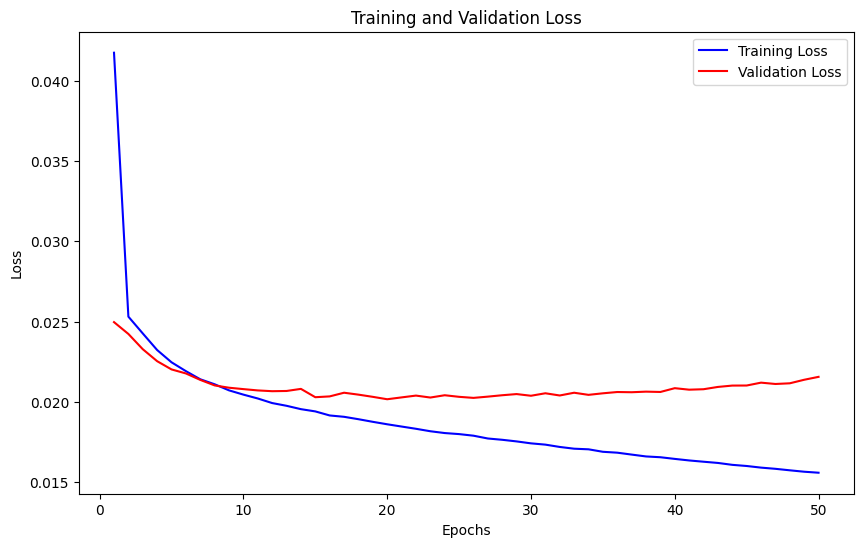

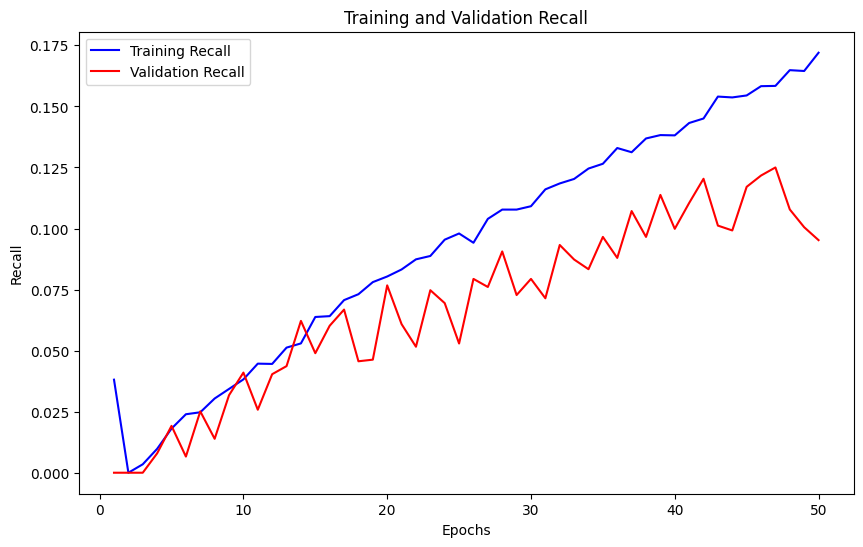

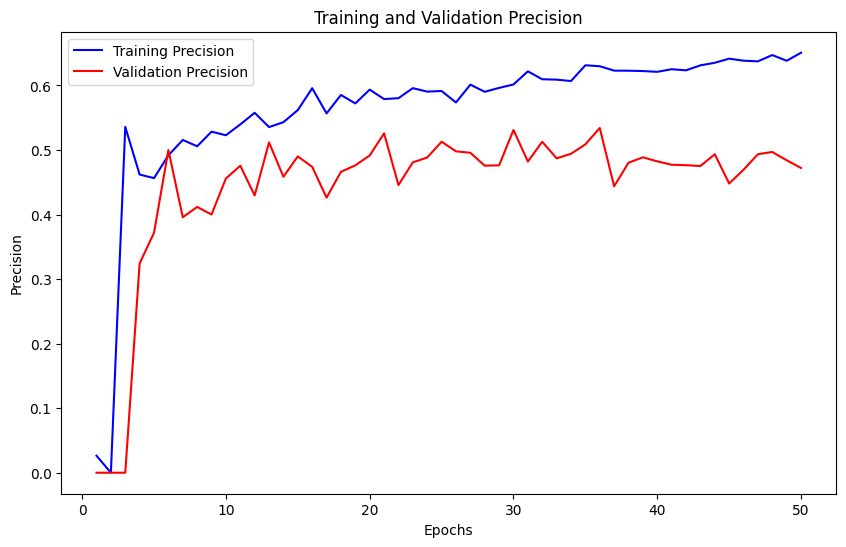

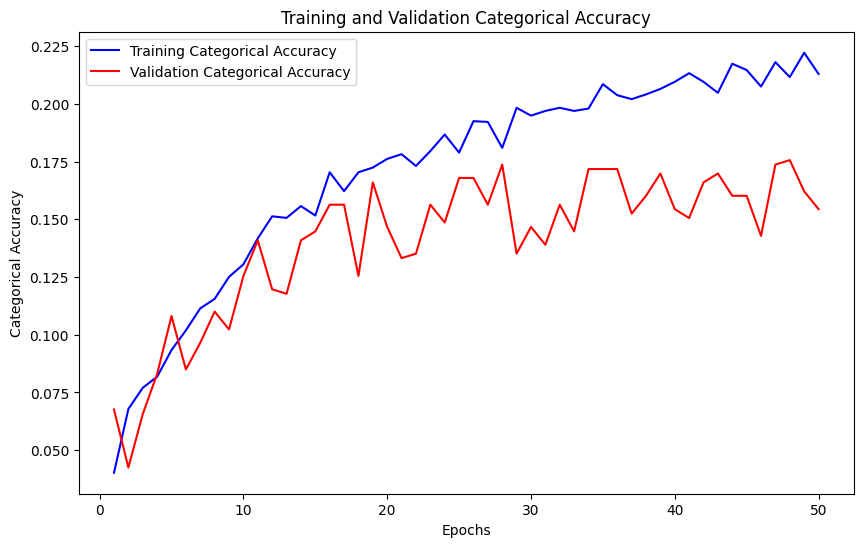

In [39]:
hist_keys = list(history.history.keys())
hist_names = ["Loss", "Recall", "Precision", "Categorical Accuracy"]

for i in range(int(len(hist_keys)/2)):

  # Plotting the curves
  epochs_list = range(1, epochs + 1)

  plt.figure(figsize=(10, 6))
  plt.plot(epochs_list, history.history[hist_keys[i]], 'b-', label='Training ' + hist_names[i])
  plt.plot(epochs_list, history.history[hist_keys[i+int((len(hist_keys)/2))]], 'r-', label='Validation ' + hist_names[i])
  plt.title('Training and Validation '+ hist_names[i])
  plt.xlabel('Epochs')
  plt.ylabel(hist_names[i])
  plt.legend()
  plt.show()

In [40]:
def top3_scents(output):
  """
  Takes in an output generated by the model.
  Returns the names of the top 3 scents in a list, by descending order
  """

  top3_indices = np.argsort(output[0])[::-1][:3] # sorts the output by ascending order, returns it to descending and returns the first 3. The returned values are the indexes of the output

  result = []

  for i in top3_indices:
    result.append(unique_classes_series[i])

  return result

In [41]:
def compare_results(received_output, expected_output, ordered=False):
  """
  Returns the amount of correctly guessed smells as %
  received_output, expected_output: list
  received_output must be bigger or equal than expected_output (this method uses the length of received_output for the comparisons)
  ordered: take the order of the smell into account when comparing. default: false
  """

  if type(received_output) != list or type(expected_output) != list:
    raise Exception("Constraint not respected: args received_output, expected_output must be lists")

  #if len(received_output) < len(expected_output):
  #  raise Exception("Constraint not respected: len(received_output) >= len(expected_output)")

  matches = 0

  if not ordered:
    for i in received_output:
      if i in expected_output:
        matches += 1

  else:
    for i in range(len(received_output)):
      if received_output[i] == expected_output[i]:
        matches+=1

  if len(received_output) > len(expected_output):
    return (matches/len(expected_output))

  return (matches/len(received_output))

In [42]:
epochs = 20
model_nn_descr.fit(X_train_descr, y_train, epochs=epochs, batch_size=32, validation_split=0.15, verbose=2)

Epoch 1/20
92/92 - 1s - loss: 0.0155 - recall: 0.1696 - precision: 0.6550 - categorical_accuracy: 0.2154 - val_loss: 0.0213 - val_recall: 0.1177 - val_precision: 0.4635 - val_categorical_accuracy: 0.1583 - 729ms/epoch - 8ms/step
Epoch 2/20
92/92 - 1s - loss: 0.0154 - recall: 0.1775 - precision: 0.6446 - categorical_accuracy: 0.2198 - val_loss: 0.0216 - val_recall: 0.0966 - val_precision: 0.4932 - val_categorical_accuracy: 0.1699 - 610ms/epoch - 7ms/step
Epoch 3/20
92/92 - 1s - loss: 0.0153 - recall: 0.1787 - precision: 0.6486 - categorical_accuracy: 0.2236 - val_loss: 0.0216 - val_recall: 0.1329 - val_precision: 0.4537 - val_categorical_accuracy: 0.1680 - 677ms/epoch - 7ms/step
Epoch 4/20
92/92 - 1s - loss: 0.0153 - recall: 0.1804 - precision: 0.6524 - categorical_accuracy: 0.2164 - val_loss: 0.0217 - val_recall: 0.1144 - val_precision: 0.4651 - val_categorical_accuracy: 0.1544 - 513ms/epoch - 6ms/step
Epoch 5/20
92/92 - 1s - loss: 0.0151 - recall: 0.1844 - precision: 0.6686 - categori

In [43]:
test_loss, test_recall, test_precision, test_accuracy = model_nn_descr.evaluate(X_test_descr, y_test, verbose=2)

14/14 - 0s - loss: 0.0240 - recall: 0.1561 - precision: 0.4502 - categorical_accuracy: 0.1667 - 50ms/epoch - 4ms/step


In [44]:
# Evaluate models
nn_y_pred_descr = model_nn_descr.predict(X_test_descr)

top_3_indices_nn = tf.argsort(nn_y_pred_descr, direction='DESCENDING')[:, :3]

top_3_labels_Noraml_nn = np.array([[unique_smells_1[index] for index in example_indices] for example_indices in top_3_indices_nn]).tolist()
print(top_3_labels_Noraml_nn)

nn_results_d = np.zeros(nn_y_pred_descr.shape)
for row in range(top_3_indices_nn.shape[0]):
  indices = top_3_indices_nn[row]
  nn_results_d[row, indices] = 1


accuracy_d = accuracy_score(y_test, nn_results_d)
precision_d = precision_score(y_test, nn_results_d, average='samples')
recall_d = recall_score(y_test, nn_results_d, average='samples')
f1_d = f1_score(y_test, nn_results_d, average='samples')
hamming_loss_d = hamming_loss(y_test, nn_results_d)
jaccard_d = jaccard_score(y_test, nn_results_d, average='samples')

print("Validation Set Metrics:")
print(f"Accuracy: {accuracy_d:.2f}")
print(f"Precision: {precision_d:.2f}")
print(f"Recall: {recall_d:.2f}")
print(f"F1-score: {f1_d:.2f}")
print(f"Hamming Loss: {hamming_loss_d:.2f}")
print(f"Jaccard Score: {jaccard_d:.2f}")

14/14 [==============================] - 0s 2ms/step
[['balsamic', 'rose', 'fruity'], ['fruity', 'herbal', 'woody'], ['fruity', 'mint', 'cooling'], ['vanilla', 'dairy', 'balsamic'], ['camphor', 'earthy', 'resinous'], ['resinous', 'cooling', 'mint'], ['seafood', 'earthy', 'ammoniac'], ['rose', 'fruity', 'floral'], ['fruity', 'fatty', 'fresh'], ['vanilla', 'anisic', 'fruity'], ['fruity', 'fresh', 'ethereal'], ['balsamic', 'fresh', 'anisic'], ['herbal', 'fresh', 'citrus'], ['floral', 'hyacinth', 'citrus'], ['fruity', 'woody', 'rose'], ['ethereal', 'fresh', 'fermented'], ['roasted', 'cacao', 'cooked'], ['nut', 'caramellic', 'earthy'], ['fruity', 'fresh', 'violetflower'], ['mint', 'fresh', 'fruity'], ['ethereal', 'chemical', 'fruity'], ['balsamic', 'earthy', 'woody'], ['sulfuric', 'chemical', 'rancid'], ['fruity', 'fatty', 'oily'], ['sulfuric', 'citrus', 'mint'], ['syrup', 'mint', 'sweet'], ['camphor', 'resinous', 'coniferous'], ['fresh', 'fruity', 'apple'], ['fruity', 'hyacinth', 'floral']

No0:


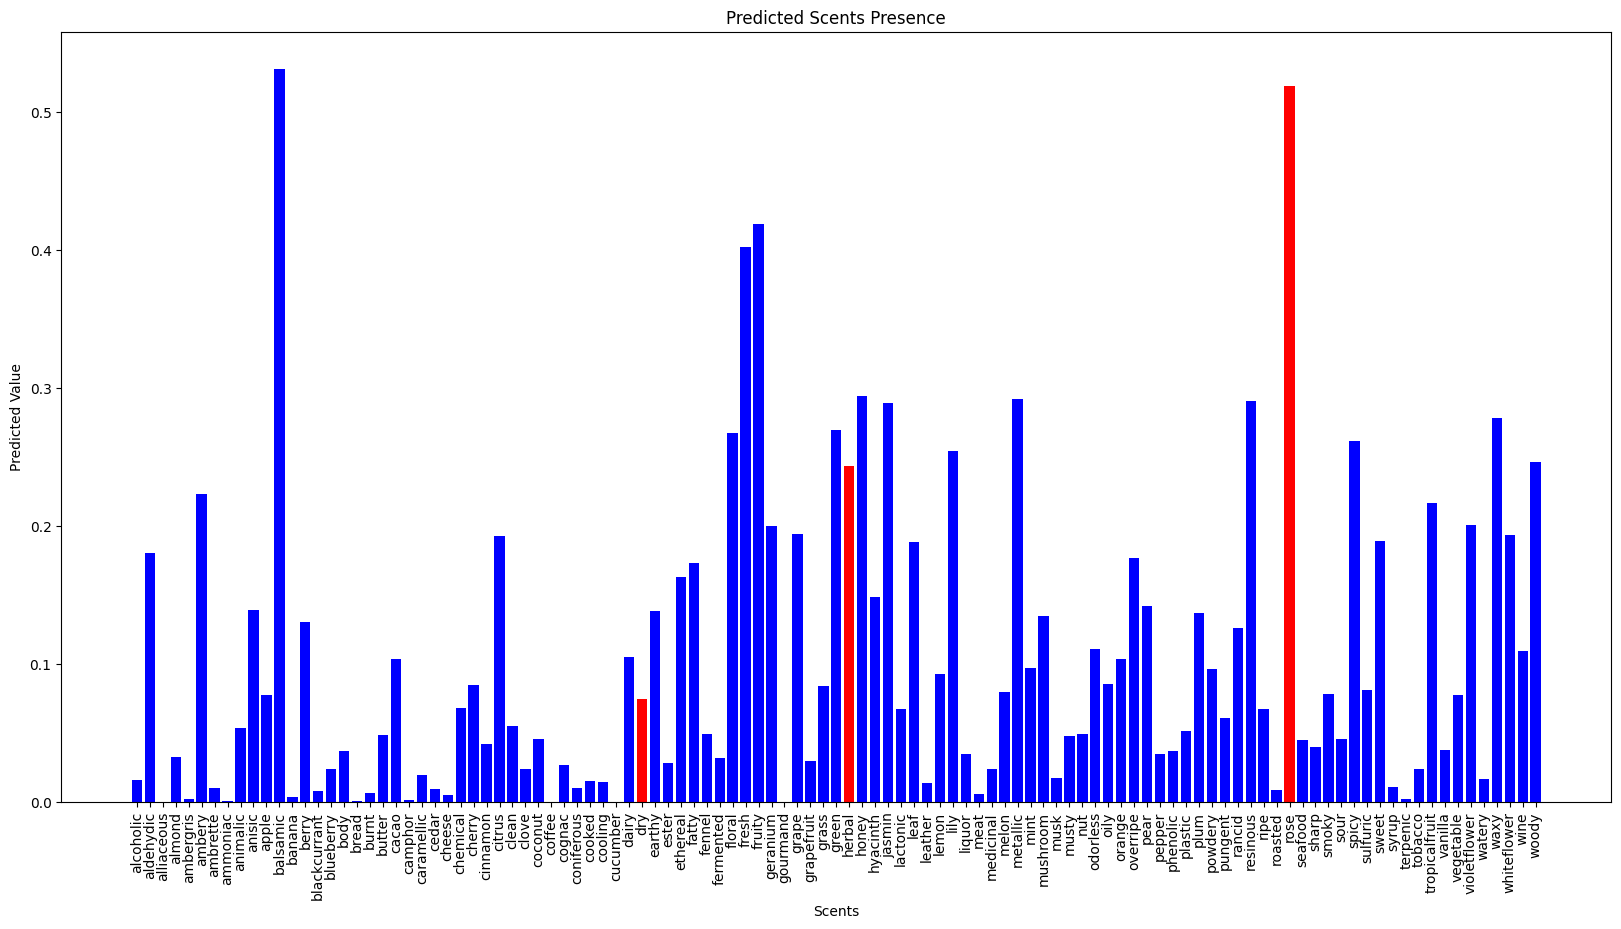

['dry', 'herbal', 'rose']

No1:


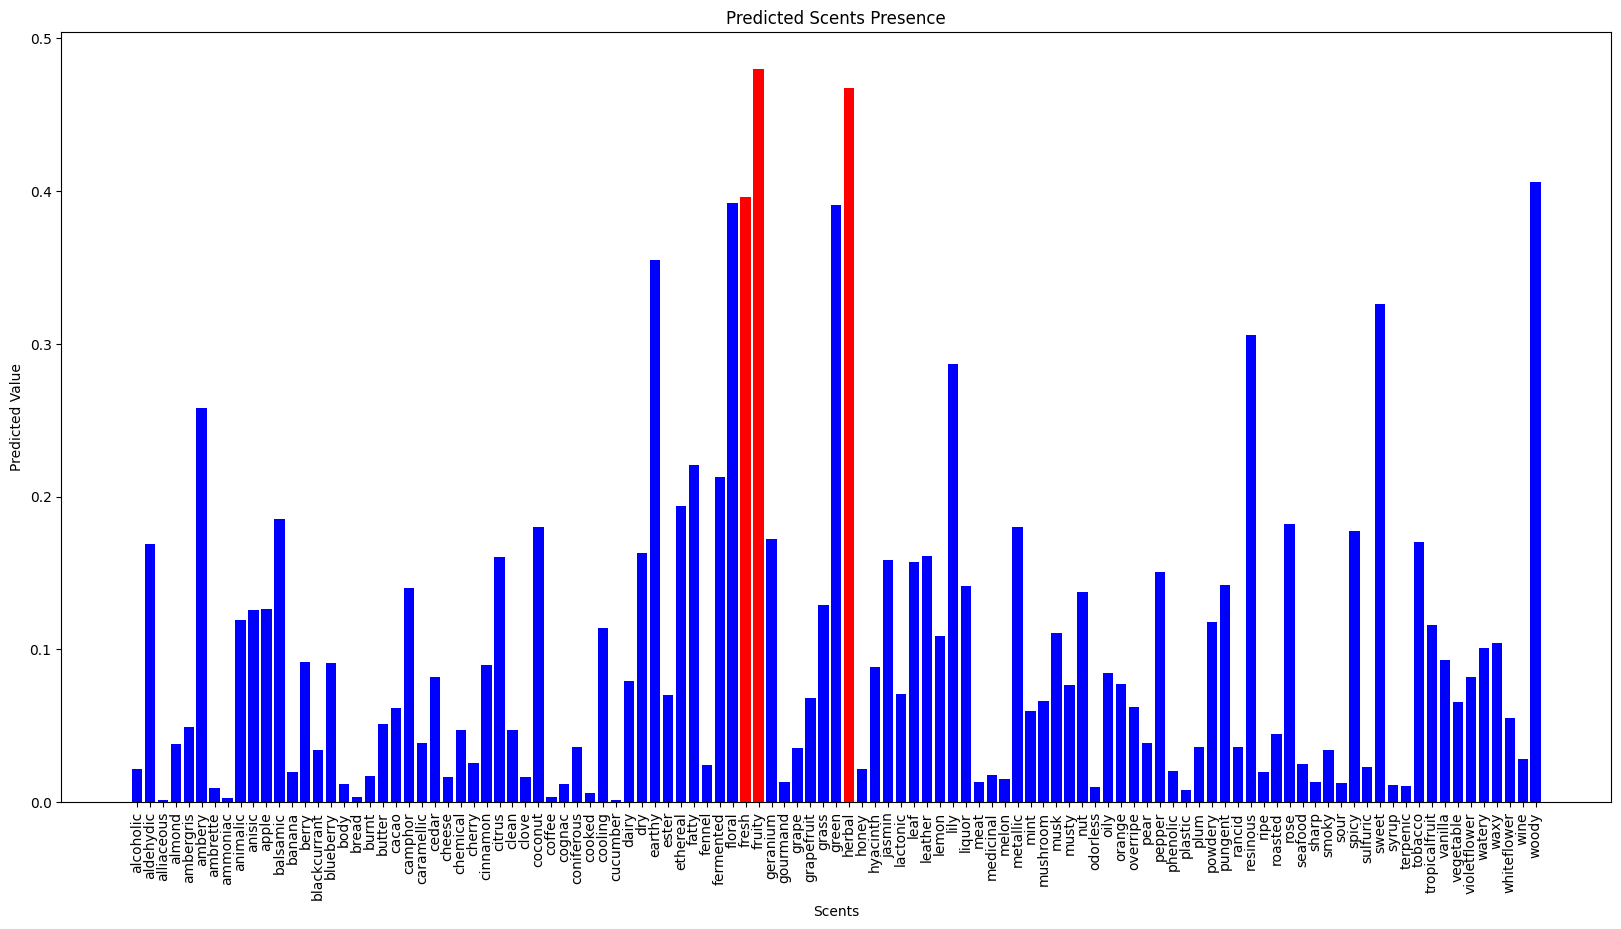

['fresh', 'fruity', 'herbal']

No2:


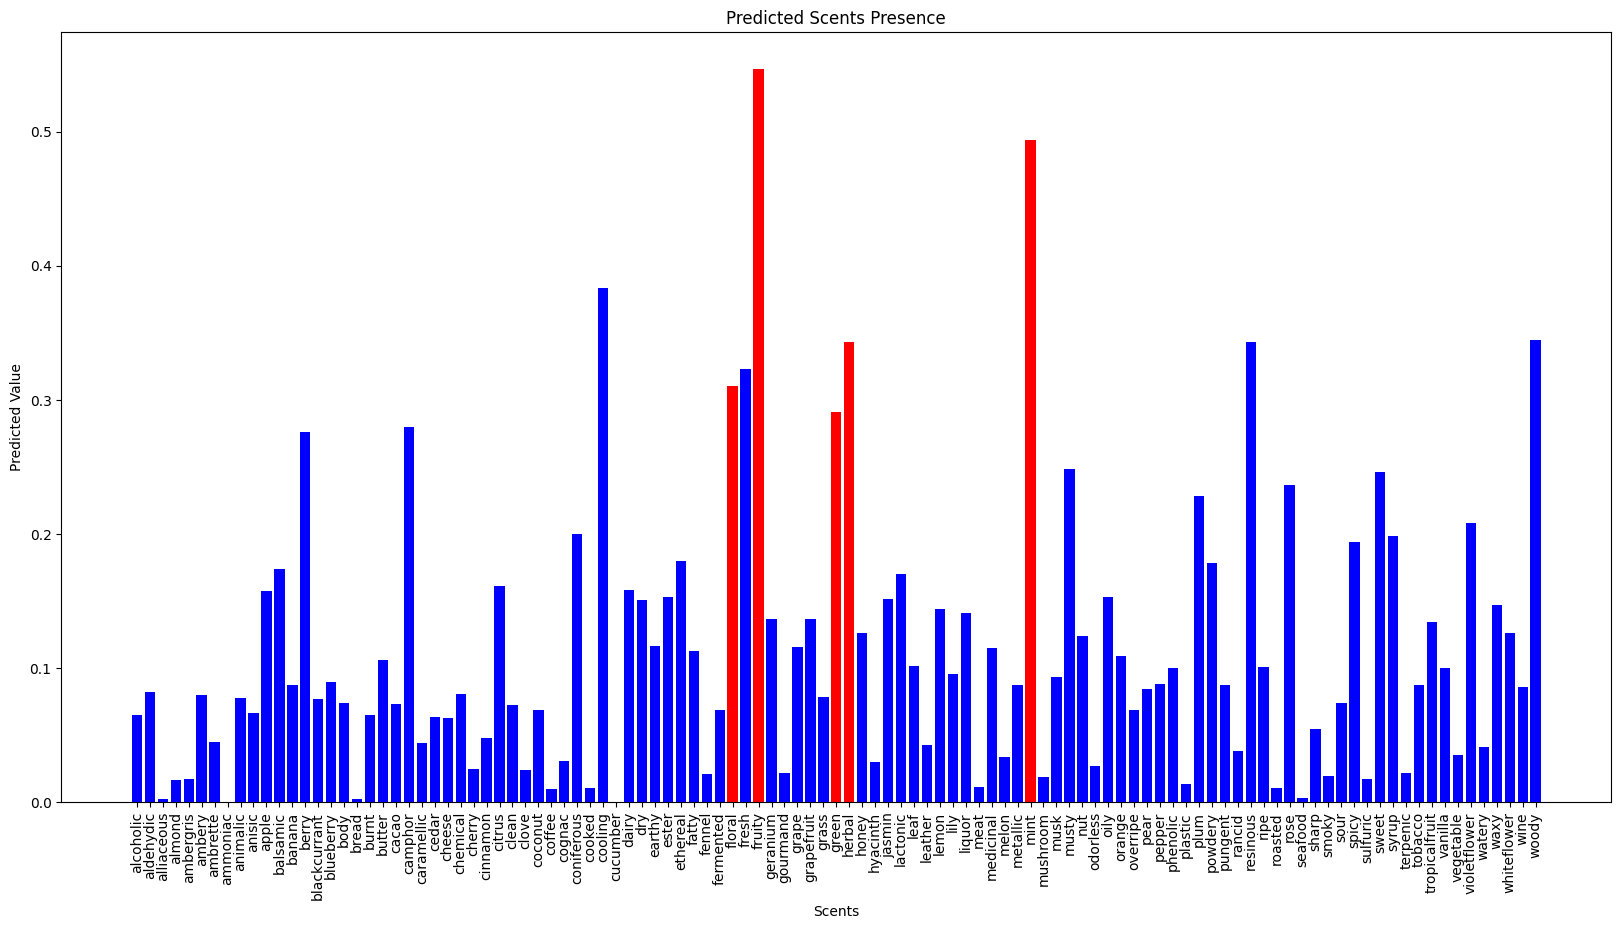

['floral', 'fruity', 'green', 'herbal', 'mint']

No3:


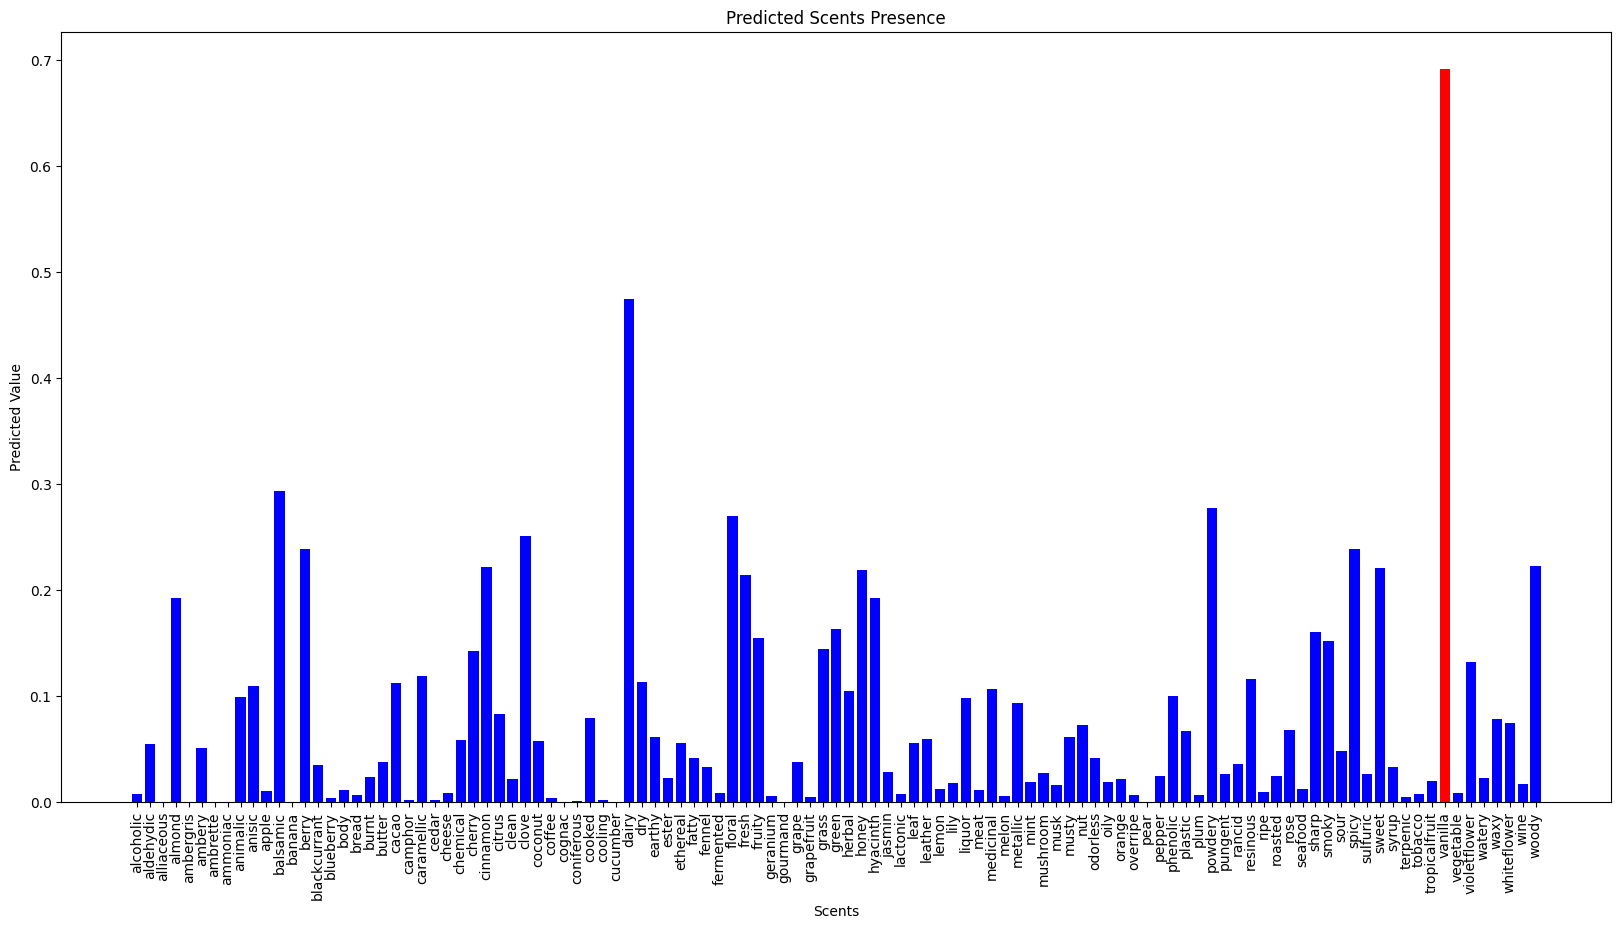

['vanilla']

No4:


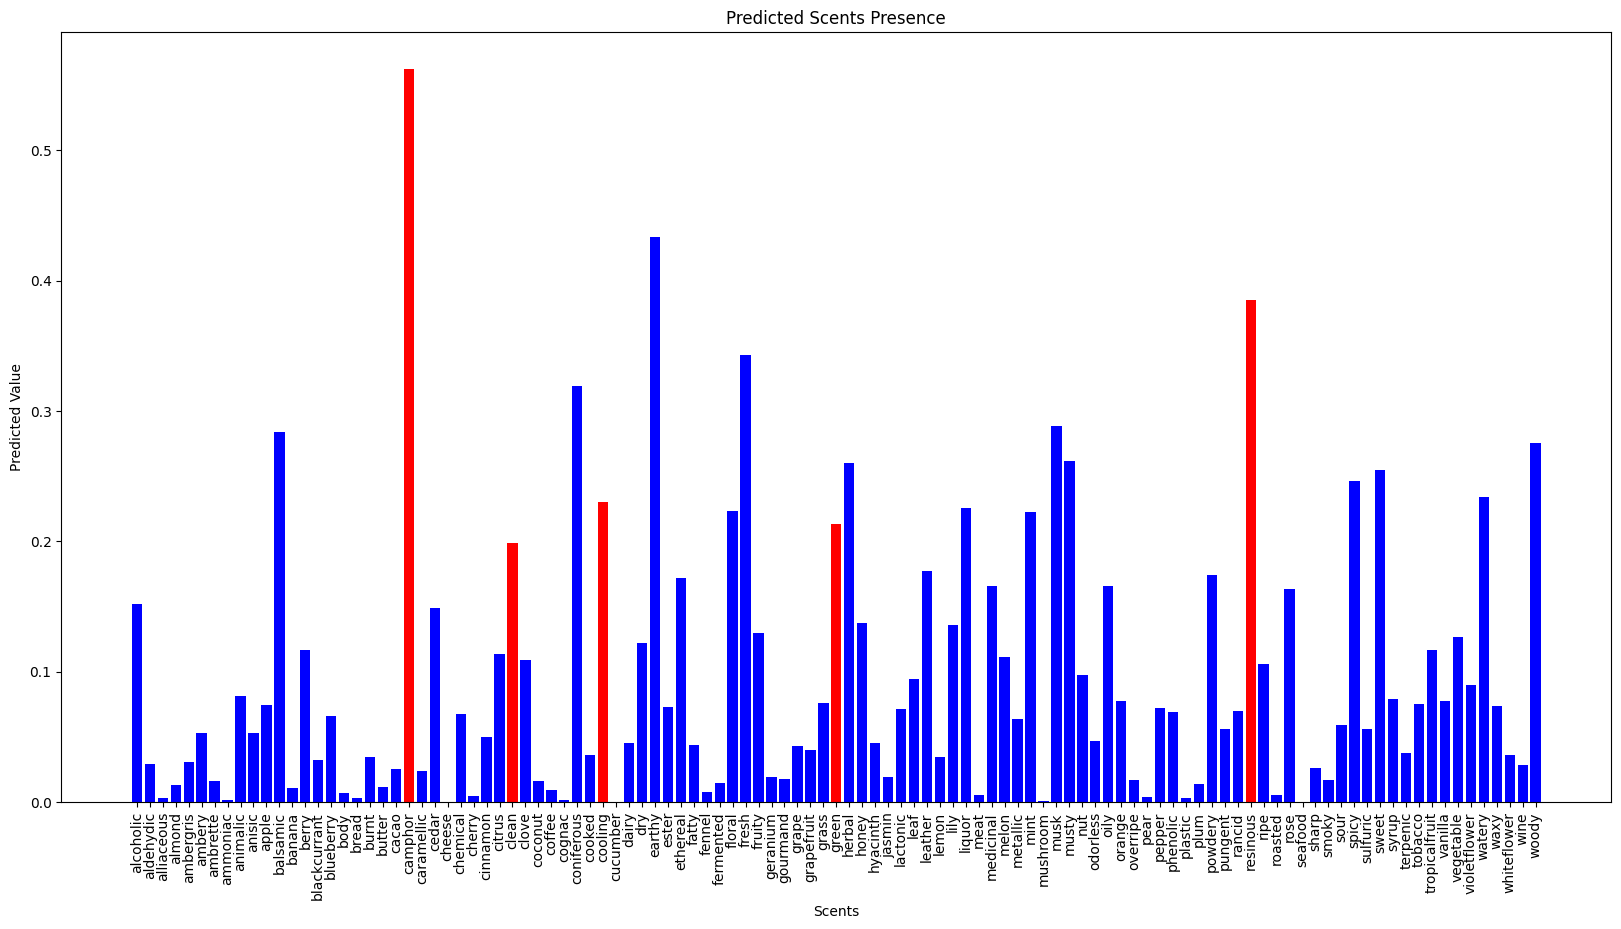

['camphor', 'clean', 'cooling', 'green', 'resinous']

No5:


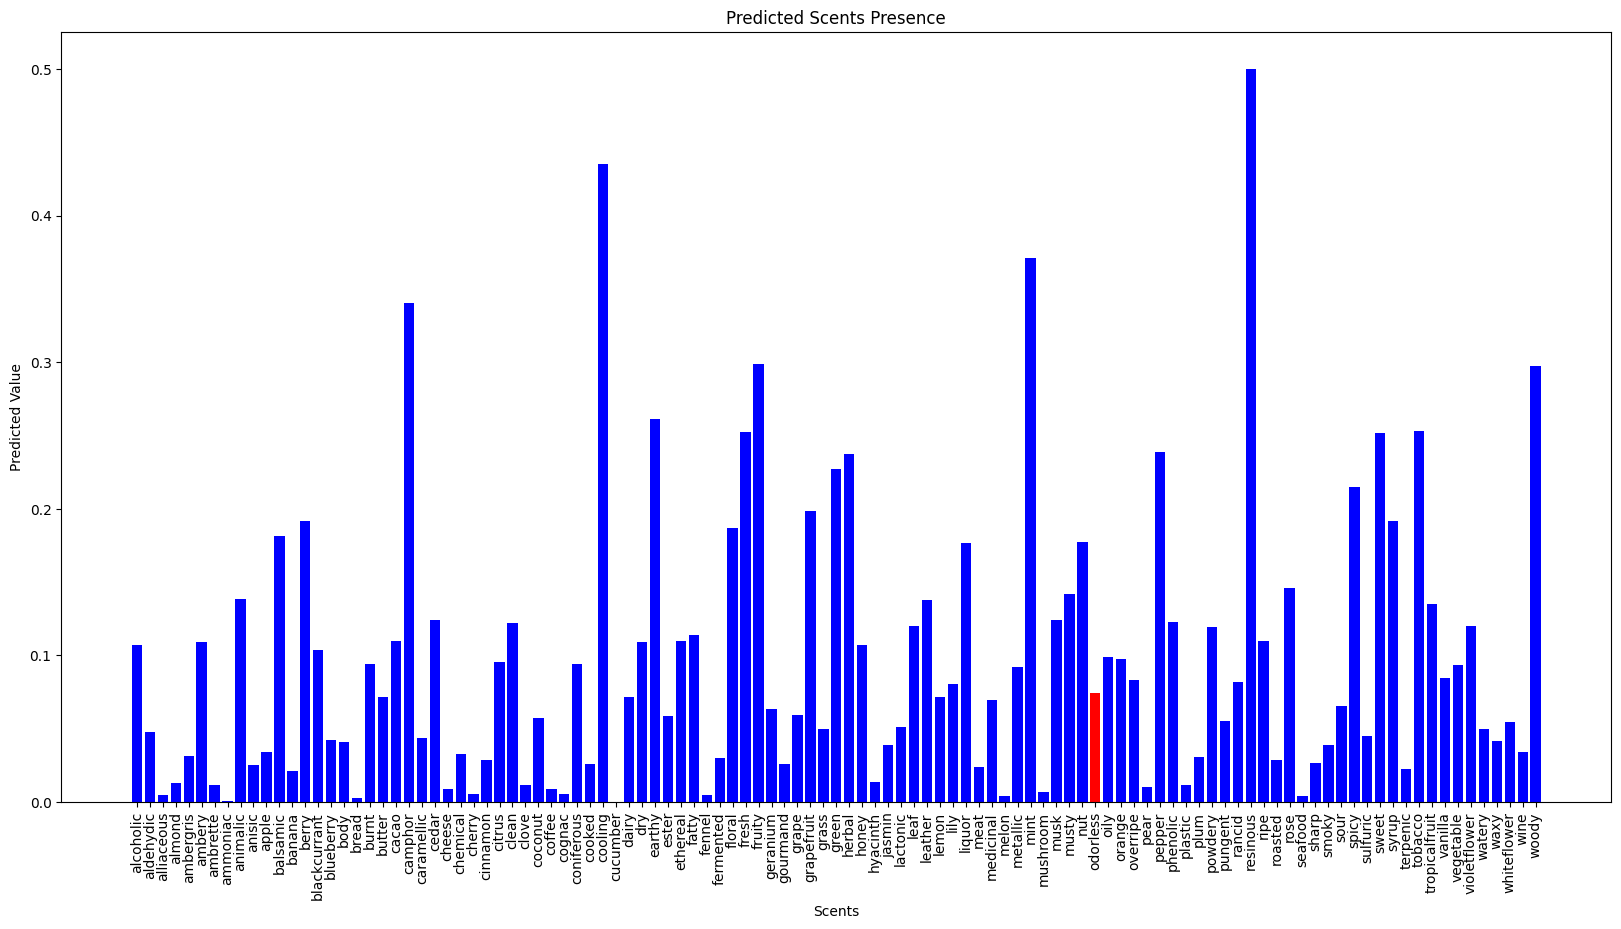

['odorless']



In [45]:
count=0
for i in range(X_test_descr.shape[0]):

  count+=1

  print(f"No{i}:")
  output = model_nn_descr.predict(tf.reshape(X_test_descr[i], (1, -1)), verbose=0) # generate the output

  # Labels for each scent (replace with actual scent names)
  scents = unique_classes_series

  # Create a bar plot
  plt.figure(figsize=(20, 10))  # Adjust the size as needed

  expected_scents = output_to_scent(y_test[i])

  # Plot each bar individually
  for j in range(len(scents)):
      color = 'red' if scents[j] in expected_scents else 'blue'  # Red for real scents, blue otherwise
      plt.bar(scents[j], output[0][j], color=color)

  # Adding labels and title
  plt.xlabel('Scents')
  plt.ylabel('Predicted Value')
  plt.title('Predicted Scents Presence')

  # Rotate labels on X-axis for better readability
  plt.xticks(rotation=90)

  # Show the plot
  plt.show()

  print(output_to_scent(y_test[i]))
  print()

  if count > 5:
    break


In [46]:
sum_similarity = 0

count = 0
for i in range(X_test_descr.shape[0]):

  #print(f"No {i+1}:")
  #print(test_smiles[i])

  # probability for each scent
  output = model_nn_descr.predict(tf.reshape(X_test_descr[i],(1, -1)), verbose=0) # generate the output

  # list of expected scents
  expected_scents = output_to_scent(y_test[i])

  # Labels for each scent (replace with actual scent names)
  scents = unique_classes_series

  # top 3 scents of the received output
  top3 = top3_scents(output)

  #print(f"Received smells: {top3} vs {expected_scents}")

  # compute the metric
  similarity = compare_results(top3, expected_scents)

  #print("Similarity:",similarity)

  sum_similarity += similarity

  count += 1

metric = sum_similarity/count

print("Overall similarity:", metric)


Overall similarity: 0.40663580246913544


In [47]:
# save results
test_df['Normal_NN_DESCRIPTORS_labels'] = top_3_labels_Noraml_nn
test_df[['SMILES', 'SENTENCE', 'BR_DESCRIPTORS_labels', 'BR_FINGERPRINTS_labels', 'Normal_NN_DESCRIPTORS_labels']]

,SMILES,SENTENCE,BR_DESCRIPTORS_labels,BR_FINGERPRINTS_labels,Normal_NN_DESCRIPTORS_labels
1483,CC(=CCCC(C)CCOC(=O)c1ccccc1)C,"dry,herbal,rose","[balsamic, floral, green]","[balsamic, floral, fruity]","[balsamic, rose, fruity]"
3591,CCCCCCC1(C)OCC(CO1)(C)C,"fruity,herbal,fresh","[herbal, fruity, floral]","[herbal, fruity, woody]","[fruity, herbal, woody]"
1017,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1OC(=O)C,"fruity,mint,herbal,floral,green","[fruity, mint, cooling]","[mint, fruity, cooling]","[fruity, mint, cooling]"
2016,O=C/C=C/c1ccc(c(c1)OC)O,vanilla,"[vanilla, spicy, fruity]","[vanilla, spicy, floral]","[vanilla, dairy, balsamic]"
2495,CC1(C)[C@@H]2CC[C@@](C)(C2)[C@@H]1O,"clean,cooling,camphor,green,resinous","[camphor, resinous, woody]","[fresh, ethereal, earthy]","[camphor, earthy, resinous]"
...,...,...,...,...,...
2997,OCCC1CCCCC1,"fermented,floral,oily,fresh","[lily, cooling, waxy]","[lily, cooling, waxy]","[fresh, lily, fruity]"
4176,CCCC(=O)OC/C=C(\CCC=C(C)C)/C,"citrus,floral,fatty,fresh","[waxy, green, apple]","[fruity, rose, floral]","[rose, fruity, green]"
305,OCCOc1ccc(cc1N)N.Cl.Cl,odorless,"[balsamic, sweet, almond]","[vanilla, rose, resinous]","[balsamic, woody, green]"
2887,Cc1cc(C)c(cc1C)C,"chemical,roasted,camphor","[camphor, roasted, chemical]","[chemical, green, fresh]","[camphor, roasted, chemical]"


### Optimized with KerasTuner

In [ ]:
### input variable: X_train_descr, X_val_descr, X_test_descr
### target variables: y_train, y_val, y_test

## save results in 'NN_DESCRIPTORS_labels' --> [top_1_odor, top_2_odor, top_3_odor] --> KEEP ORDER IMPORTANT!!!

In [48]:
# # Split data in features and labels
# # Descriptors
# labels = molecule_data_descriptors['SENTENCE'].str.split(',')
# inputSize = molecule_data_descriptors.shape[1]-2
# input_data = molecule_data_descriptors.iloc[:, 2:]
inputSize = X_train_descr.shape[1]
# # Transform labels into binarized vectors
# mlb = MultiLabelBinarizer()
# all_vectors = mlb.fit_transform(labels)

# # Split into train, val and test set
# x_train, x_temp, y_train, y_temp = train_test_split(input_data, all_vectors, test_size=0.2, random_state=42)
# x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [49]:
def build_tuning_model_d(hp):
  model = Sequential()
  # First input layer
  model.add(Dense(input_dim=inputSize, units=hp.Int(
                                                    'inputDense',
                                                    min_value=32,
                                                    max_value=512,
                                                    step=32),
                                       activation=hp.Choice('input_activation',
                                                  values=['relu', 'sigmoid', 'tanh'])))
  model.add(Dense(
            units=hp.Int(
                  'dense1',
                  min_value=32,
                  max_value=512,
                  step=32
                  ),
            activation=hp.Choice(
                  'dense1_activation',
                  values=['relu', 'sigmoid', 'tanh']
                  )))
  model.add(Dense(
            units=hp.Int(
                  'dense2',
                  min_value=32,
                  max_value=512,
                  step=32
                  ),
            activation=hp.Choice(
                  'dense2_activation',
                  values=['relu', 'sigmoid', 'tanh']
                  )))
  model.add(Dense(
            units=hp.Int(
                  'dense3',
                  min_value=32,
                  max_value=512,
                  step=32
                  ),
            activation=hp.Choice(
                  'dense3_activation',
                  values=['relu', 'sigmoid', 'tanh']
                  )))
  model.add(Dense(109, activation='sigmoid'))

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics='accuracy')
  return model

tuner_d = kt.Hyperband(
    build_tuning_model_d,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='hyperband',
    project_name='optimized_nn',
    overwrite=True
)

In [50]:
# Implement early-stopping to prevent overfitting
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Start the search for best hyperparameters
tuner_d.search(X_train_descr, y_train, epochs=50, validation_data=(X_val_descr, y_val), callbacks=[early_stop])

# Get the best hyperparameters and build the model
best_hps_d = tuner_d.get_best_hyperparameters(num_trials=1)[0]
optimized_model_d = tuner_d.hypermodel.build(best_hps_d)

Trial 90 Complete [00h 00m 05s]
val_loss: 0.11211622506380081

Best val_loss So Far: 0.09053610265254974
Total elapsed time: 00h 11m 12s


In [51]:
print(best_hps_d.values)

{'inputDense': 352, 'input_activation': 'relu', 'dense1': 96, 'dense1_activation': 'tanh', 'dense2': 448, 'dense2_activation': 'relu', 'dense3': 512, 'dense3_activation': 'tanh', 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0058'}


{'inputDense': 480, 'input_activation': 'tanh', 'dense1': 352, 'dense1_activation': 'sigmoid', 'dense2': 480, 'dense2_activation': 'relu', 'dense3': 160, 'dense3_activation': 'relu', 'tuner/epochs': 50, 'tuner/initial_epoch': 17, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0074'}


In [52]:
# Fit the optimal model
optimized_model_d.fit(X_train_descr, y_train, epochs=50, batch_size=32, validation_data=(X_val_descr, y_val), callbacks=[early_stop])

Epoch 1/50
108/108 [==============================] - 6s 13ms/step - loss: 0.1387 - accuracy: 0.0594 - val_loss: 0.1142 - val_accuracy: 0.0694
Epoch 2/50
108/108 [==============================] - 1s 7ms/step - loss: 0.1130 - accuracy: 0.0594 - val_loss: 0.1145 - val_accuracy: 0.0856
Epoch 3/50
108/108 [==============================] - 0s 5ms/step - loss: 0.1115 - accuracy: 0.0559 - val_loss: 0.1102 - val_accuracy: 0.0833
Epoch 4/50
108/108 [==============================] - 0s 5ms/step - loss: 0.1068 - accuracy: 0.0747 - val_loss: 0.1065 - val_accuracy: 0.0787
Epoch 5/50
108/108 [==============================] - 0s 4ms/step - loss: 0.1027 - accuracy: 0.0837 - val_loss: 0.1035 - val_accuracy: 0.0787
Epoch 6/50
108/108 [==============================] - 0s 5ms/step - loss: 0.0992 - accuracy: 0.0936 - val_loss: 0.1007 - val_accuracy: 0.0949
Epoch 7/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0959 - accuracy: 0.1104 - val_loss: 0.0992 - val_accuracy: 0.1227
Epoch

In [53]:
# Evaluate models
opt_y_pred_d = optimized_model_d.predict(X_test_descr)

top_3_indices_nn = tf.argsort(opt_y_pred_d, direction='DESCENDING')[:, :3]

top_3_labels_Opt_nn = np.array([[unique_smells_1[index] for index in example_indices] for example_indices in top_3_indices_nn]).tolist()
print(top_3_labels_Opt_nn)

OPT_results_d = np.zeros(opt_y_pred_d.shape)
for row in range(top_3_indices_nn.shape[0]):
  indices = top_3_indices_nn[row]
  OPT_results_d[row, indices] = 1


accuracy_d = accuracy_score(y_test, OPT_results_d)
precision_d = precision_score(y_test, OPT_results_d, average='samples')
recall_d = recall_score(y_test, OPT_results_d, average='samples')
f1_d = f1_score(y_test, OPT_results_d, average='samples')
hamming_loss_d = hamming_loss(y_test, OPT_results_d)
jaccard_d = jaccard_score(y_test, OPT_results_d, average='samples')

print("Validation Set Metrics:")
print(f"Accuracy: {accuracy_d:.2f}")
print(f"Precision: {precision_d:.2f}")
print(f"Recall: {recall_d:.2f}")
print(f"F1-score: {f1_d:.2f}")
print(f"Hamming Loss: {hamming_loss_d:.2f}")
print(f"Jaccard Score: {jaccard_d:.2f}")

14/14 [==============================] - 0s 2ms/step
[['balsamic', 'rose', 'honey'], ['floral', 'fruity', 'woody'], ['fruity', 'mint', 'woody'], ['vanilla', 'sweet', 'balsamic'], ['camphor', 'coniferous', 'resinous'], ['camphor', 'coniferous', 'mint'], ['seafood', 'earthy', 'ammoniac'], ['floral', 'rose', 'fruity'], ['fruity', 'oily', 'fatty'], ['sweet', 'floral', 'vanilla'], ['pungent', 'fruity', 'almond'], ['balsamic', 'resinous', 'spicy'], ['spicy', 'herbal', 'resinous'], ['floral', 'herbal', 'green'], ['woody', 'fruity', 'floral'], ['fresh', 'fermented', 'ethereal'], ['caramellic', 'sweet', 'nut'], ['caramellic', 'nut', 'earthy'], ['fruity', 'floral', 'fatty'], ['mint', 'cooling', 'fresh'], ['fruity', 'chemical', 'ethereal'], ['musk', 'animalic', 'balsamic'], ['alliaceous', 'sulfuric', 'chemical'], ['fruity', 'oily', 'waxy'], ['sulfuric', 'citrus', 'floral'], ['syrup', 'caramellic', 'sweet'], ['camphor', 'coniferous', 'fresh'], ['fruity', 'vegetable', 'musty'], ['floral', 'sweet', 

In [54]:
test_df['OPT_NN_DESCRIPTORS_labels'] = top_3_labels_Opt_nn
test_df[['SMILES', 'SENTENCE', 'BR_DESCRIPTORS_labels', 'BR_FINGERPRINTS_labels', 'Normal_NN_DESCRIPTORS_labels', 'OPT_NN_DESCRIPTORS_labels']]

,SMILES,SENTENCE,BR_DESCRIPTORS_labels,BR_FINGERPRINTS_labels,Normal_NN_DESCRIPTORS_labels,OPT_NN_DESCRIPTORS_labels
1483,CC(=CCCC(C)CCOC(=O)c1ccccc1)C,"dry,herbal,rose","[balsamic, floral, green]","[balsamic, floral, fruity]","[balsamic, rose, fruity]","[balsamic, rose, honey]"
3591,CCCCCCC1(C)OCC(CO1)(C)C,"fruity,herbal,fresh","[herbal, fruity, floral]","[herbal, fruity, woody]","[fruity, herbal, woody]","[floral, fruity, woody]"
1017,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1OC(=O)C,"fruity,mint,herbal,floral,green","[fruity, mint, cooling]","[mint, fruity, cooling]","[fruity, mint, cooling]","[fruity, mint, woody]"
2016,O=C/C=C/c1ccc(c(c1)OC)O,vanilla,"[vanilla, spicy, fruity]","[vanilla, spicy, floral]","[vanilla, dairy, balsamic]","[vanilla, sweet, balsamic]"
2495,CC1(C)[C@@H]2CC[C@@](C)(C2)[C@@H]1O,"clean,cooling,camphor,green,resinous","[camphor, resinous, woody]","[fresh, ethereal, earthy]","[camphor, earthy, resinous]","[camphor, coniferous, resinous]"
...,...,...,...,...,...,...
2997,OCCC1CCCCC1,"fermented,floral,oily,fresh","[lily, cooling, waxy]","[lily, cooling, waxy]","[fresh, lily, fruity]","[fermented, lily, fresh]"
4176,CCCC(=O)OC/C=C(\CCC=C(C)C)/C,"citrus,floral,fatty,fresh","[waxy, green, apple]","[fruity, rose, floral]","[rose, fruity, green]","[fruity, rose, floral]"
305,OCCOc1ccc(cc1N)N.Cl.Cl,odorless,"[balsamic, sweet, almond]","[vanilla, rose, resinous]","[balsamic, woody, green]","[resinous, spicy, rose]"
2887,Cc1cc(C)c(cc1C)C,"chemical,roasted,camphor","[camphor, roasted, chemical]","[chemical, green, fresh]","[camphor, roasted, chemical]","[camphor, chemical, pungent]"


## NN + FINGERPRINTS

### Without Optimization

In [55]:
### input variable: X_train_finger, X_val_finger, X_test_finger
### target variables: y_train, y_val, y_test

## save results in 'NN_FINGERPRINTS_labels' --> [top_1_odor, top_2_odor, top_3_odor] --> KEEP ORDER IMPORTANT!!!

In [56]:
df = df_fingerprints
inputSize = df.shape[1]-4 #-4 because the first 4 columns are the SMILES and expected output

inputSize = inputSize
outputSize = unique_classes_series.size
learning_rate = 0.1

print(inputSize)

2048


In [58]:
model_nn_finger = Sequential()
model_nn_finger.add(Dense(inputSize, input_dim=inputSize, activation='relu'))
model_nn_finger.add(Dense(128, activation='relu'))
model_nn_finger.add(Dense(len(unique_classes_series), activation='sigmoid'))  # Output layer

model_nn_finger.compile(loss=FocalLoss, optimizer='adam', metrics=[Recall(), Precision(), CategoricalAccuracy()])

epochs = 20
model_nn_finger.fit(X_train_finger, y_train, epochs=epochs, batch_size=32, validation_split=0.15, verbose=2)

Epoch 1/20
92/92 - 3s - loss: 0.0351 - recall_1: 0.0358 - precision_1: 0.0426 - categorical_accuracy: 0.0706 - val_loss: 0.0229 - val_recall_1: 0.0185 - val_precision_1: 0.4516 - val_categorical_accuracy: 0.1332 - 3s/epoch - 32ms/step
Epoch 2/20
92/92 - 0s - loss: 0.0202 - recall_1: 0.0612 - precision_1: 0.6356 - categorical_accuracy: 0.1554 - val_loss: 0.0220 - val_recall_1: 0.0635 - val_precision_1: 0.4824 - val_categorical_accuracy: 0.1486 - 436ms/epoch - 5ms/step
Epoch 3/20
92/92 - 0s - loss: 0.0163 - recall_1: 0.1549 - precision_1: 0.7133 - categorical_accuracy: 0.2260 - val_loss: 0.0223 - val_recall_1: 0.1230 - val_precision_1: 0.4559 - val_categorical_accuracy: 0.1390 - 452ms/epoch - 5ms/step
Epoch 4/20
92/92 - 1s - loss: 0.0134 - recall_1: 0.2786 - precision_1: 0.7362 - categorical_accuracy: 0.2652 - val_loss: 0.0234 - val_recall_1: 0.1786 - val_precision_1: 0.4066 - val_categorical_accuracy: 0.1525 - 623ms/epoch - 7ms/step
Epoch 5/20
92/92 - 1s - loss: 0.0112 - recall_1: 0.387

In [59]:
# Evaluate models
nn_y_pred_finger = model_nn_finger.predict(X_test_finger)

top_3_indices_nn = tf.argsort(nn_y_pred_finger, direction='DESCENDING')[:, :3]

top_3_labels_Normal_nn = np.array([[unique_smells_1[index] for index in example_indices] for example_indices in top_3_indices_nn]).tolist()
print(top_3_labels_Normal_nn)

NN_results_d = np.zeros(nn_y_pred_finger.shape)
for row in range(top_3_indices_nn.shape[0]):
  indices = top_3_indices_nn[row]
  NN_results_d[row, indices] = 1


accuracy_d = accuracy_score(y_test, NN_results_d)
precision_d = precision_score(y_test, NN_results_d, average='samples')
recall_d = recall_score(y_test, NN_results_d, average='samples')
f1_d = f1_score(y_test, NN_results_d, average='samples')
hamming_loss_d = hamming_loss(y_test, NN_results_d)
jaccard_d = jaccard_score(y_test, NN_results_d, average='samples')

print("Validation Set Metrics:")
print(f"Accuracy: {accuracy_d:.2f}")
print(f"Precision: {precision_d:.2f}")
print(f"Recall: {recall_d:.2f}")
print(f"F1-score: {f1_d:.2f}")
print(f"Hamming Loss: {hamming_loss_d:.2f}")
print(f"Jaccard Score: {jaccard_d:.2f}")

14/14 [==============================] - 0s 3ms/step
[['balsamic', 'floral', 'green'], ['herbal', 'fruity', 'floral'], ['fruity', 'mint', 'berry'], ['vanilla', 'powdery', 'cinnamon'], ['camphor', 'earthy', 'woody'], ['herbal', 'green', 'tobacco'], ['sulfuric', 'rancid', 'chemical'], ['rose', 'citrus', 'fresh'], ['citrus', 'fruity', 'cooked'], ['powdery', 'balsamic', 'sweet'], ['green', 'fruity', 'ethereal'], ['balsamic', 'green', 'vanilla'], ['spicy', 'fresh', 'mint'], ['citrus', 'fresh', 'floral'], ['fruity', 'berry', 'grape'], ['citrus', 'ethereal', 'floral'], ['coffee', 'floral', 'powdery'], ['nut', 'caramellic', 'earthy'], ['green', 'fruity', 'waxy'], ['mint', 'cooling', 'camphor'], ['chemical', 'fruity', 'fresh'], ['phenolic', 'fruity', 'medicinal'], ['sulfuric', 'alliaceous', 'vegetable'], ['oily', 'fruity', 'waxy'], ['green', 'mint', 'sulfuric'], ['woody', 'fruity', 'metallic'], ['fresh', 'camphor', 'citrus'], ['leaf', 'fresh', 'green'], ['green', 'fruity', 'herbal'], ['balsamic

In [60]:
# save results
test_df['Normal_NN_FINGERPRINTS_labels'] = top_3_labels_Normal_nn
test_df[['SMILES', 'SENTENCE', 'BR_DESCRIPTORS_labels', 'BR_FINGERPRINTS_labels', 'Normal_NN_DESCRIPTORS_labels', 'Normal_NN_FINGERPRINTS_labels']]

,SMILES,SENTENCE,BR_DESCRIPTORS_labels,BR_FINGERPRINTS_labels,Normal_NN_DESCRIPTORS_labels,Normal_NN_FINGERPRINTS_labels
1483,CC(=CCCC(C)CCOC(=O)c1ccccc1)C,"dry,herbal,rose","[balsamic, floral, green]","[balsamic, floral, fruity]","[balsamic, rose, fruity]","[balsamic, floral, green]"
3591,CCCCCCC1(C)OCC(CO1)(C)C,"fruity,herbal,fresh","[herbal, fruity, floral]","[herbal, fruity, woody]","[fruity, herbal, woody]","[herbal, fruity, floral]"
1017,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1OC(=O)C,"fruity,mint,herbal,floral,green","[fruity, mint, cooling]","[mint, fruity, cooling]","[fruity, mint, cooling]","[fruity, mint, berry]"
2016,O=C/C=C/c1ccc(c(c1)OC)O,vanilla,"[vanilla, spicy, fruity]","[vanilla, spicy, floral]","[vanilla, dairy, balsamic]","[vanilla, powdery, cinnamon]"
2495,CC1(C)[C@@H]2CC[C@@](C)(C2)[C@@H]1O,"clean,cooling,camphor,green,resinous","[camphor, resinous, woody]","[fresh, ethereal, earthy]","[camphor, earthy, resinous]","[camphor, earthy, woody]"
...,...,...,...,...,...,...
2997,OCCC1CCCCC1,"fermented,floral,oily,fresh","[lily, cooling, waxy]","[lily, cooling, waxy]","[fresh, lily, fruity]","[cooling, lily, waxy]"
4176,CCCC(=O)OC/C=C(\CCC=C(C)C)/C,"citrus,floral,fatty,fresh","[waxy, green, apple]","[fruity, rose, floral]","[rose, fruity, green]","[green, waxy, apple]"
305,OCCOc1ccc(cc1N)N.Cl.Cl,odorless,"[balsamic, sweet, almond]","[vanilla, rose, resinous]","[balsamic, woody, green]","[rose, geranium, mushroom]"
2887,Cc1cc(C)c(cc1C)C,"chemical,roasted,camphor","[camphor, roasted, chemical]","[chemical, green, fresh]","[camphor, roasted, chemical]","[chemical, phenolic, camphor]"


### Optimized with KerasTuner

In [61]:
inputSizeFingerprints = X_train_finger.shape[1]

In [62]:
def build_tuning_model_f(hp):
  model = Sequential()
  # First input layer
  model.add(Dense(input_dim=inputSizeFingerprints, units=hp.Int(
                                                    'inputDense',
                                                    min_value=32,
                                                    max_value=512,
                                                    step=32),
                                       activation=hp.Choice('input_activation',
                                                  values=['relu', 'sigmoid', 'tanh'])))
  model.add(Dense(
            units=hp.Int(
                  'dense1',
                  min_value=32,
                  max_value=512,
                  step=32
                  ),
            activation=hp.Choice(
                  'dense1_activation',
                  values=['relu', 'sigmoid', 'tanh']
                  )))
  model.add(Dense(
            units=hp.Int(
                  'dense2',
                  min_value=32,
                  max_value=512,
                  step=32
                  ),
            activation=hp.Choice(
                  'dense2_activation',
                  values=['relu', 'sigmoid', 'tanh']
                  )))
  model.add(Dense(
            units=hp.Int(
                  'dense3',
                  min_value=32,
                  max_value=512,
                  step=32
                  ),
            activation=hp.Choice(
                  'dense3_activation',
                  values=['relu', 'sigmoid', 'tanh']
                  )))
  model.add(Dense(109, activation='sigmoid'))

  model.compile(optimizer='adam',
                loss='binary_crossentropy',
                metrics='accuracy')
  return model

tuner_f = kt.Hyperband(
    build_tuning_model_f,
    objective='val_loss',
    max_epochs=50,
    factor=3,
    directory='hyperband_f',
    project_name='optimized_nn',
    overwrite=True
)

In [63]:
# Implement early-stopping to prevent overfitting
early_stop = callbacks.EarlyStopping(monitor='val_loss', patience=3)

# Start the search for best hyperparameters
tuner_f.search(X_train_finger, y_train, epochs=50, validation_data=(X_val_finger, y_val), callbacks=[early_stop])

# Get the best hyperparameters and build the model
best_hps_f = tuner_f.get_best_hyperparameters(num_trials=1)[0]
optimized_model_f = tuner_f.hypermodel.build(best_hps_f)

Trial 90 Complete [00h 00m 29s]
val_loss: 0.0977691113948822

Best val_loss So Far: 0.09576281905174255
Total elapsed time: 00h 10m 13s


In [64]:
print(best_hps_f.values)

{'inputDense': 256, 'input_activation': 'relu', 'dense1': 64, 'dense1_activation': 'tanh', 'dense2': 320, 'dense2_activation': 'relu', 'dense3': 512, 'dense3_activation': 'sigmoid', 'tuner/epochs': 6, 'tuner/initial_epoch': 2, 'tuner/bracket': 3, 'tuner/round': 1, 'tuner/trial_id': '0015'}


{'inputDense': 320, 'input_activation': 'tanh', 'dense1': 224, 'dense1_activation': 'tanh', 'dense2': 96, 'dense2_activation': 'relu', 'dense3': 416, 'dense3_activation': 'sigmoid', 'tuner/epochs': 17, 'tuner/initial_epoch': 6, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0062'}


In [65]:
optimized_model_f.fit(X_train_finger, y_train, epochs=50, batch_size=32, validation_data=(X_val_finger, y_val), callbacks=[early_stop])

Epoch 1/50
108/108 [==============================] - 2s 6ms/step - loss: 0.1380 - accuracy: 0.0536 - val_loss: 0.1111 - val_accuracy: 0.1065
Epoch 2/50
108/108 [==============================] - 1s 5ms/step - loss: 0.1043 - accuracy: 0.0762 - val_loss: 0.1017 - val_accuracy: 0.0833
Epoch 3/50
108/108 [==============================] - 1s 5ms/step - loss: 0.0954 - accuracy: 0.1234 - val_loss: 0.0977 - val_accuracy: 0.1042
Epoch 4/50
108/108 [==============================] - 0s 5ms/step - loss: 0.0890 - accuracy: 0.1475 - val_loss: 0.0968 - val_accuracy: 0.1157
Epoch 5/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0836 - accuracy: 0.1738 - val_loss: 0.0963 - val_accuracy: 0.1157
Epoch 6/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0780 - accuracy: 0.1984 - val_loss: 0.0975 - val_accuracy: 0.1412
Epoch 7/50
108/108 [==============================] - 0s 4ms/step - loss: 0.0731 - accuracy: 0.2193 - val_loss: 0.0990 - val_accuracy: 0.1389
Epoch 

In [66]:
opt_y_pred_f = optimized_model_f.predict(X_test_finger)

top_3_indices_nn_f = tf.argsort(opt_y_pred_f, direction='DESCENDING')[:, :3]

opt_top_3_labels_nn_f = np.array([[unique_smells_1[index] for index in example_indices] for example_indices in top_3_indices_nn_f]).tolist()
print(opt_top_3_labels_nn_f)

opt_results_f = np.zeros(opt_y_pred_f.shape)
for row in range(top_3_indices_nn_f.shape[0]):
  indices = top_3_indices_nn_f[row]
  opt_results_f[row, indices] = 1

accuracy_f = accuracy_score(y_test, opt_results_f)
precision_f = precision_score(y_test, opt_results_f, average='samples')
recall_f = recall_score(y_test, opt_results_f, average='samples')
f1_f = f1_score(y_test, opt_results_f, average='samples')
hamming_loss_f = hamming_loss(y_test, opt_results_f)
jaccard_f = jaccard_score(y_test, opt_results_f, average='samples')

print("Validation Set Metrics:")
print(f"Accuracy: {accuracy_f:.2f}")
print(f"Precision: {precision_f:.2f}")
print(f"Recall: {recall_f:.2f}")
print(f"F1-score: {f1_f:.2f}")
print(f"Hamming Loss: {hamming_loss_f:.2f}")
print(f"Jaccard Score: {jaccard_f:.2f}")

14/14 [==============================] - 0s 3ms/step
[['rose', 'floral', 'green'], ['herbal', 'fruity', 'floral'], ['mint', 'fruity', 'fresh'], ['vanilla', 'almond', 'spicy'], ['resinous', 'camphor', 'green'], ['odorless', 'berry', 'fruity'], ['sulfuric', 'tropicalfruit', 'meat'], ['rose', 'floral', 'fruity'], ['fruity', 'fatty', 'green'], ['balsamic', 'vanilla', 'sweet'], ['fruity', 'green', 'cacao'], ['balsamic', 'fruity', 'sweet'], ['fresh', 'herbal', 'pungent'], ['fresh', 'floral', 'lily'], ['fresh', 'fruity', 'herbal'], ['fresh', 'ethereal', 'camphor'], ['nut', 'coffee', 'meat'], ['nut', 'coffee', 'cacao'], ['green', 'fruity', 'resinous'], ['mint', 'cooling', 'camphor'], ['fruity', 'ethereal', 'fresh'], ['floral', 'resinous', 'balsamic'], ['sulfuric', 'meat', 'alliaceous'], ['fruity', 'oily', 'fatty'], ['green', 'floral', 'lemon'], ['burnt', 'caramellic', 'fruity'], ['fresh', 'camphor', 'mint'], ['green', 'vegetable', 'ethereal'], ['floral', 'herbal', 'sweet'], ['balsamic', 'flora

In [67]:
test_df['OPT_NN_FINGERPRINTS_labels'] = opt_top_3_labels_nn_f
test_df[['SMILES', 'SENTENCE', 'BR_DESCRIPTORS_labels', 'BR_FINGERPRINTS_labels', 'Normal_NN_DESCRIPTORS_labels', 'OPT_NN_DESCRIPTORS_labels', 'Normal_NN_FINGERPRINTS_labels', 'OPT_NN_FINGERPRINTS_labels']]

,SMILES,SENTENCE,BR_DESCRIPTORS_labels,BR_FINGERPRINTS_labels,Normal_NN_DESCRIPTORS_labels,OPT_NN_DESCRIPTORS_labels,Normal_NN_FINGERPRINTS_labels,OPT_NN_FINGERPRINTS_labels
1483,CC(=CCCC(C)CCOC(=O)c1ccccc1)C,"dry,herbal,rose","[balsamic, floral, green]","[balsamic, floral, fruity]","[balsamic, rose, fruity]","[balsamic, rose, honey]","[balsamic, floral, green]","[rose, floral, green]"
3591,CCCCCCC1(C)OCC(CO1)(C)C,"fruity,herbal,fresh","[herbal, fruity, floral]","[herbal, fruity, woody]","[fruity, herbal, woody]","[floral, fruity, woody]","[herbal, fruity, floral]","[herbal, fruity, floral]"
1017,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1OC(=O)C,"fruity,mint,herbal,floral,green","[fruity, mint, cooling]","[mint, fruity, cooling]","[fruity, mint, cooling]","[fruity, mint, woody]","[fruity, mint, berry]","[mint, fruity, fresh]"
2016,O=C/C=C/c1ccc(c(c1)OC)O,vanilla,"[vanilla, spicy, fruity]","[vanilla, spicy, floral]","[vanilla, dairy, balsamic]","[vanilla, sweet, balsamic]","[vanilla, powdery, cinnamon]","[vanilla, almond, spicy]"
2495,CC1(C)[C@@H]2CC[C@@](C)(C2)[C@@H]1O,"clean,cooling,camphor,green,resinous","[camphor, resinous, woody]","[fresh, ethereal, earthy]","[camphor, earthy, resinous]","[camphor, coniferous, resinous]","[camphor, earthy, woody]","[resinous, camphor, green]"
...,...,...,...,...,...,...,...,...
2997,OCCC1CCCCC1,"fermented,floral,oily,fresh","[lily, cooling, waxy]","[lily, cooling, waxy]","[fresh, lily, fruity]","[fermented, lily, fresh]","[cooling, lily, waxy]","[fresh, lily, floral]"
4176,CCCC(=O)OC/C=C(\CCC=C(C)C)/C,"citrus,floral,fatty,fresh","[waxy, green, apple]","[fruity, rose, floral]","[rose, fruity, green]","[fruity, rose, floral]","[green, waxy, apple]","[apple, green, fruity]"
305,OCCOc1ccc(cc1N)N.Cl.Cl,odorless,"[balsamic, sweet, almond]","[vanilla, rose, resinous]","[balsamic, woody, green]","[resinous, spicy, rose]","[rose, geranium, mushroom]","[floral, balsamic, rose]"
2887,Cc1cc(C)c(cc1C)C,"chemical,roasted,camphor","[camphor, roasted, chemical]","[chemical, green, fresh]","[camphor, roasted, chemical]","[camphor, chemical, pungent]","[chemical, phenolic, camphor]","[chemical, camphor, phenolic]"


# 7. Model 3: Graph NN


In [68]:
### input variable: SMILES_train, SMILES_val, SMILES_test
### target variables: y_train, y_val, y_test

## save results in 'GNN_labels' --> [top_1_odor, top_2_odor, top_3_odor] --> KEEP ORDER IMPORTANT!!!

## Graph embeddings
First we need to create the Graph encoder that will generate graph embeddings of the molecules from the smiles of the molecules.


In [69]:
## Create the Graph encoder to generate graph embeddings from the smiles

# Define the encoder for the atoms, this defines what
atom_encoder = chemistry.Featurizer([
    chemistry.features.Symbol(),
    chemistry.features.Hybridization(),
    chemistry.features.CIPCode(),
    chemistry.features.ChiralCenter(),
    chemistry.features.FormalCharge(),
    chemistry.features.TotalNumHs(),
    chemistry.features.TotalValence(),
    chemistry.features.NumRadicalElectrons(),
    chemistry.features.Degree(),
    chemistry.features.Aromatic(),
    chemistry.features.Hetero(),
    chemistry.features.HydrogenDonor(),
    chemistry.features.HydrogenAcceptor(),
    chemistry.features.RingSize(),
    chemistry.features.Ring(),
    chemistry.features.CrippenLogPContribution(),
    chemistry.features.CrippenMolarRefractivityContribution(),
    chemistry.features.TPSAContribution(),
    chemistry.features.LabuteASAContribution(),
    chemistry.features.GasteigerCharge()
])

#Define the encoder for the bonds
bond_encoder = chemistry.Featurizer([
    chemistry.features.BondType(),
    chemistry.features.Conjugated(),
    chemistry.features.Rotatable(),
    chemistry.features.Stereo()
    # ...
])

# encoder = chemistry.MolecularGraphEncoder(atom_encoder, bond_encoder, molecule_from_string_fn = Chem.MolFromSmiles())
encoder = chemistry.MolecularGraphEncoder(atom_encoder, bond_encoder)


Now we can use the defined encoder to generate the embeddings for our train, test and validation datasets.

In [70]:
# Put input data in right format
train_inputs = encoder(train_df["SMILES"].tolist())
train_outputs = train_df["multi"].tolist()
train_outputs = [list(map(int, s.strip('[]').split(', '))) for s in train_outputs]
train_outputs_tensor = tf.convert_to_tensor(train_outputs)


#put validation data in right format
val_inputs = encoder(val_df["SMILES"].tolist())
val_outputs = val_df["multi"].tolist()
val_outputs = [list(map(int, s.strip('[]').split(', '))) for s in val_outputs]
val_outputs_tensor = tf.convert_to_tensor(val_outputs)


#put test data in right format
test_inputs = encoder(test_df["SMILES"].tolist())
test_outputs = test_df["multi"].tolist()
test_outputs = [list(map(int, s.strip('[]').split(', '))) for s in test_outputs]
test_outputs_tensor = tf.convert_to_tensor(test_outputs)


Next we need to reshape the tensors to be consistent with the desired input and output shapes of our model.

In [71]:
training_dataset = tf.data.Dataset.from_tensor_slices((train_inputs, train_outputs_tensor))

# print(train_outputs_tensor.shape)
# print(val_outputs_tensor.shape)
# print(val_outputs_tensor.shape[0])
# print(val_outputs_tensor.shape[1])

val_outputs_tensor_reshaped = tf.reshape(val_outputs_tensor, (val_outputs_tensor.shape[0], 1, val_outputs_tensor.shape[1]))
validation_dataset = tf.data.Dataset.from_tensor_slices((val_inputs, val_outputs_tensor_reshaped))

# print(test_outputs_tensor.shape)
# print(test_outputs_tensor.shape[0])
# print(test_outputs_tensor.shape[1])
test_outputs_tensor_reshaped = tf.reshape(test_outputs_tensor, (test_outputs_tensor.shape[0], 1, test_outputs_tensor.shape[1]))
test_dataset = tf.data.Dataset.from_tensor_slices((test_inputs, test_outputs_tensor))

## Model definition and training
Now we have prepared our data for use in a Graph Neural Network we need to define our model itself.

The model hyperparameters used are the following:

**Model layers:** \\
**Layer 1:** Graph Convolutional Layer, size 64 \\
**Layer 2:** Graph Convolutional Layer, size 32 \\
**Layer 3:** Dense layer, size 128, ReLu \\
**Layer 4:** Dense layer, size 64, ReLu \\
**Output layer:** Dense Layer, size 109, Sigmoid

We did some experiments with different model parameters such as layer size, nuber of layers etc. and these parameters achieved optimal results.

Optimizer: \\
The optimizer used is the Adam optimizer with a learning rate of 0.007. Using higher learning rates resulted in unstable behaviour during the learning process.

In [72]:
# Build model via Keras API
gnn_model = keras.Sequential([

    #Graph Convolutional Layers
    layers.MPNNConv(units=64, name='gat_conv_1'),
    layers.MPNNConv(units=32, name='gat_conv_2'),

    layers.Readout(),

    # Feed forward layers
    keras.layers.Dense(units = 128, activation = 'relu'),
    keras.layers.Dense(units = 64, activation = 'relu'),

    # Outut Layer
    keras.layers.Dense(units=109, activation='sigmoid')
])


# from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

opt = keras.optimizers.Adam(learning_rate=0.0007)

gnn_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=[Recall(), Precision(),  CategoricalAccuracy()])


Now we have created our model we can train it on our training data.

In [73]:

callbacks = [
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, restore_best_weights=True, start_from_epoch=30),
]

gnn_model.fit(training_dataset.batch(32), epochs=100, batch_size=32, validation_data = validation_dataset, callbacks=callbacks)



Epoch 1/100
108/108 [==============================] - 11s 31ms/step - loss: 0.2528 - recall: 0.0573 - precision: 0.0267 - categorical_accuracy: 0.0458 - val_loss: 0.1126 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_categorical_accuracy: 0.0856
Epoch 2/100
108/108 [==============================] - 3s 31ms/step - loss: 0.1110 - recall: 0.0000e+00 - precision: 0.0000e+00 - categorical_accuracy: 0.0707 - val_loss: 0.1124 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_categorical_accuracy: 0.0556
Epoch 3/100
108/108 [==============================] - 3s 26ms/step - loss: 0.1109 - recall: 0.0000e+00 - precision: 0.0000e+00 - categorical_accuracy: 0.0695 - val_loss: 0.1123 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_categorical_accuracy: 0.0556
Epoch 4/100
108/108 [==============================] - 3s 26ms/step - loss: 0.1108 - recall: 0.0000e+00 - precision: 0.0000e+00 - categorical_accuracy: 0.0698 - val_loss: 0.1122 - val_recall: 0.0000e+00 - val_

## Results
Now we can run the model on our test data to evaluate it's performance on unseen data.

In [74]:
test_metrics = gnn_model.evaluate(test_dataset)
print(test_metrics)
test_loss, test_recall, test_precision, test_categorical_accuracy = test_metrics

432/432 [==============================] - 3s 5ms/step - loss: 0.0941 - recall: 0.0235 - precision: 0.4615 - categorical_accuracy: 0.1551
[0.09414352476596832, 0.0235294122248888, 0.4615384638309479, 0.15509259700775146]


In [75]:
# Evaluate models
predictions = gnn_model.predict(test_dataset)

432/432 [==============================] - 2s 3ms/step


In [76]:
print(predictions.shape)
# Get the indices of the top 3 values for each example along axis 1
top_3_indices = tf.argsort(predictions, direction='DESCENDING')[:, :3]

# Now top_k_indices has shape (432, 3) containing the indices of the top 3 values for each example
print(top_3_indices.numpy())

(432, 109)
[[ 46  48  11]
 [ 46 108  47]
 [ 69  48 108]
 ...
 [108  95  46]
 [ 21  61  25]
 [ 46 105  48]]


### Output to 3 smells
From the indices of the top 3 smells we can recover the sentences.

In [77]:
# Map the indices to the labels
top_3_labels_gnn = np.array([[unique_smells_1[index] for index in example_indices] for example_indices in top_3_indices])
print(top_3_labels_gnn)


[['floral' 'fruity' 'balsamic']
 ['floral' 'woody' 'fresh']
 ['mint' 'fruity' 'woody']
 ...
 ['woody' 'sulfuric' 'floral']
 ['camphor' 'leather' 'chemical']
 ['floral' 'waxy' 'fruity']]


In [79]:
# save results in test dataframe
test_df['GNN_labels'] = [row for row in top_3_labels_gnn]
test_df[['SMILES', 'SENTENCE', 'BR_DESCRIPTORS_labels', 'BR_FINGERPRINTS_labels', 'Normal_NN_DESCRIPTORS_labels', 'OPT_NN_DESCRIPTORS_labels', 'Normal_NN_FINGERPRINTS_labels', 'OPT_NN_FINGERPRINTS_labels', 'GNN_labels']]

,SMILES,SENTENCE,BR_DESCRIPTORS_labels,BR_FINGERPRINTS_labels,Normal_NN_DESCRIPTORS_labels,OPT_NN_DESCRIPTORS_labels,Normal_NN_FINGERPRINTS_labels,OPT_NN_FINGERPRINTS_labels,GNN_labels
1483,CC(=CCCC(C)CCOC(=O)c1ccccc1)C,"dry,herbal,rose","[balsamic, floral, green]","[balsamic, floral, fruity]","[balsamic, rose, fruity]","[balsamic, rose, honey]","[balsamic, floral, green]","[rose, floral, green]","[floral, fruity, balsamic]"
3591,CCCCCCC1(C)OCC(CO1)(C)C,"fruity,herbal,fresh","[herbal, fruity, floral]","[herbal, fruity, woody]","[fruity, herbal, woody]","[floral, fruity, woody]","[herbal, fruity, floral]","[herbal, fruity, floral]","[floral, woody, fresh]"
1017,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1OC(=O)C,"fruity,mint,herbal,floral,green","[fruity, mint, cooling]","[mint, fruity, cooling]","[fruity, mint, cooling]","[fruity, mint, woody]","[fruity, mint, berry]","[mint, fruity, fresh]","[mint, fruity, woody]"
2016,O=C/C=C/c1ccc(c(c1)OC)O,vanilla,"[vanilla, spicy, fruity]","[vanilla, spicy, floral]","[vanilla, dairy, balsamic]","[vanilla, sweet, balsamic]","[vanilla, powdery, cinnamon]","[vanilla, almond, spicy]","[phenolic, balsamic, vanilla]"
2495,CC1(C)[C@@H]2CC[C@@](C)(C2)[C@@H]1O,"clean,cooling,camphor,green,resinous","[camphor, resinous, woody]","[fresh, ethereal, earthy]","[camphor, earthy, resinous]","[camphor, coniferous, resinous]","[camphor, earthy, woody]","[resinous, camphor, green]","[camphor, woody, earthy]"
...,...,...,...,...,...,...,...,...,...
2997,OCCC1CCCCC1,"fermented,floral,oily,fresh","[lily, cooling, waxy]","[lily, cooling, waxy]","[fresh, lily, fruity]","[fermented, lily, fresh]","[cooling, lily, waxy]","[fresh, lily, floral]","[fresh, floral, fruity]"
4176,CCCC(=O)OC/C=C(\CCC=C(C)C)/C,"citrus,floral,fatty,fresh","[waxy, green, apple]","[fruity, rose, floral]","[rose, fruity, green]","[fruity, rose, floral]","[green, waxy, apple]","[apple, green, fruity]","[fruity, floral, rose]"
305,OCCOc1ccc(cc1N)N.Cl.Cl,odorless,"[balsamic, sweet, almond]","[vanilla, rose, resinous]","[balsamic, woody, green]","[resinous, spicy, rose]","[rose, geranium, mushroom]","[floral, balsamic, rose]","[woody, sulfuric, floral]"
2887,Cc1cc(C)c(cc1C)C,"chemical,roasted,camphor","[camphor, roasted, chemical]","[chemical, green, fresh]","[camphor, roasted, chemical]","[camphor, chemical, pungent]","[chemical, phenolic, camphor]","[chemical, camphor, phenolic]","[camphor, leather, chemical]"


### Evaluation metrics

In [80]:
predictions_d = np.zeros(predictions.shape)
for row in range(top_3_labels_gnn.shape[0]):
  indices = top_3_indices[row]
  predictions_d[row, indices] = 1


accuracy_gnn = accuracy_score(y_test, predictions_d)
precision_gnn = precision_score(y_test, predictions_d, average='samples')
recall_gnn = recall_score(y_test, predictions_d, average='samples')
f1_gnn = f1_score(y_test, predictions_d, average='samples')
hamming_loss_gnn = hamming_loss(y_test, predictions_d)
jaccard_gnn = jaccard_score(y_test, predictions_d, average='samples')

print("Validation Set Metrics:")
print(f"Accuracy: {accuracy_gnn:.2f}")
print(f"Precision: {precision_gnn:.2f}")
print(f"Recall: {recall_gnn:.2f}")
print(f"F1-score: {f1_gnn:.2f}")
print(f"Hamming Loss: {hamming_loss_gnn:.2f}")
print(f"Jaccard Score: {jaccard_gnn:.2f}")

Validation Set Metrics:
Accuracy: 0.00
Precision: 0.29
Recall: 0.33
F1-score: 0.29
Hamming Loss: 0.04
Jaccard Score: 0.19


# 8. High Level Data Fusion

In [81]:
## get predictions from each model for the test data and save it in test_df

In [83]:
# assuming all results are stored in the adequate df with results in variables:
  # 'BR_DESCRIPTORS_labels', 'BR_FINGERPRINTS_labels', 'NN_DESCRIPTORS_labels', 'NN_FINGERPRINTS_labels', 'GNN_labels'

def data_fusion_prediction(row, columns_to_consider):

    score_dict = {}

    # Iterate over specified columns and score the odors
    for col in columns_to_consider:
        odors = row[col]
        for i, odor in enumerate(odors):
            score = 3 - i  # Scores: 3 for 1st position, 2 for 2nd, 1 for 3rd
            score_dict[odor] = score_dict.get(odor, 0) + score

    # Determine the top 3 odors based on total scores
    top_3_odors = sorted(score_dict, key=score_dict.get, reverse=True)[:3]
    return top_3_odors

# Define the columns to consider
# Order the columns according to the model that has better results
columns_to_consider = ['OPT_NN_DESCRIPTORS_labels', 'Normal_NN_DESCRIPTORS_labels',
                       'OPT_NN_FINGERPRINTS_labels', 'BR_DESCRIPTORS_labels',
                       'BR_FINGERPRINTS_labels','GNN_labels',
                       'Normal_NN_FINGERPRINTS_labels']

# Assuming df is your DataFrame
# Apply the function to each row, passing the columns to consider
test_df['DECISION_FUSION_Labels'] = test_df.apply(lambda row: data_fusion_prediction(row, columns_to_consider), axis=1)


In [84]:
test_df[['SMILES', 'SENTENCE', 'BR_DESCRIPTORS_labels', 'BR_FINGERPRINTS_labels', 'Normal_NN_DESCRIPTORS_labels', 'OPT_NN_DESCRIPTORS_labels', 'Normal_NN_FINGERPRINTS_labels', 'OPT_NN_FINGERPRINTS_labels', 'GNN_labels', 'DECISION_FUSION_Labels']]

,SMILES,SENTENCE,BR_DESCRIPTORS_labels,BR_FINGERPRINTS_labels,Normal_NN_DESCRIPTORS_labels,OPT_NN_DESCRIPTORS_labels,Normal_NN_FINGERPRINTS_labels,OPT_NN_FINGERPRINTS_labels,GNN_labels,DECISION_FUSION_Labels
1483,CC(=CCCC(C)CCOC(=O)c1ccccc1)C,"dry,herbal,rose","[balsamic, floral, green]","[balsamic, floral, fruity]","[balsamic, rose, fruity]","[balsamic, rose, honey]","[balsamic, floral, green]","[rose, floral, green]","[floral, fruity, balsamic]","[balsamic, floral, rose]"
3591,CCCCCCC1(C)OCC(CO1)(C)C,"fruity,herbal,fresh","[herbal, fruity, floral]","[herbal, fruity, woody]","[fruity, herbal, woody]","[floral, fruity, woody]","[herbal, fruity, floral]","[herbal, fruity, floral]","[floral, woody, fresh]","[herbal, fruity, floral]"
1017,CC(C)[C@@H]1CC[C@@H](C)C[C@H]1OC(=O)C,"fruity,mint,herbal,floral,green","[fruity, mint, cooling]","[mint, fruity, cooling]","[fruity, mint, cooling]","[fruity, mint, woody]","[fruity, mint, berry]","[mint, fruity, fresh]","[mint, fruity, woody]","[fruity, mint, cooling]"
2016,O=C/C=C/c1ccc(c(c1)OC)O,vanilla,"[vanilla, spicy, fruity]","[vanilla, spicy, floral]","[vanilla, dairy, balsamic]","[vanilla, sweet, balsamic]","[vanilla, powdery, cinnamon]","[vanilla, almond, spicy]","[phenolic, balsamic, vanilla]","[vanilla, spicy, balsamic]"
2495,CC1(C)[C@@H]2CC[C@@](C)(C2)[C@@H]1O,"clean,cooling,camphor,green,resinous","[camphor, resinous, woody]","[fresh, ethereal, earthy]","[camphor, earthy, resinous]","[camphor, coniferous, resinous]","[camphor, earthy, woody]","[resinous, camphor, green]","[camphor, woody, earthy]","[camphor, resinous, earthy]"
...,...,...,...,...,...,...,...,...,...,...
2997,OCCC1CCCCC1,"fermented,floral,oily,fresh","[lily, cooling, waxy]","[lily, cooling, waxy]","[fresh, lily, fruity]","[fermented, lily, fresh]","[cooling, lily, waxy]","[fresh, lily, floral]","[fresh, floral, fruity]","[lily, fresh, cooling]"
4176,CCCC(=O)OC/C=C(\CCC=C(C)C)/C,"citrus,floral,fatty,fresh","[waxy, green, apple]","[fruity, rose, floral]","[rose, fruity, green]","[fruity, rose, floral]","[green, waxy, apple]","[apple, green, fruity]","[fruity, floral, rose]","[fruity, rose, green]"
305,OCCOc1ccc(cc1N)N.Cl.Cl,odorless,"[balsamic, sweet, almond]","[vanilla, rose, resinous]","[balsamic, woody, green]","[resinous, spicy, rose]","[rose, geranium, mushroom]","[floral, balsamic, rose]","[woody, sulfuric, floral]","[balsamic, rose, woody]"
2887,Cc1cc(C)c(cc1C)C,"chemical,roasted,camphor","[camphor, roasted, chemical]","[chemical, green, fresh]","[camphor, roasted, chemical]","[camphor, chemical, pungent]","[chemical, phenolic, camphor]","[chemical, camphor, phenolic]","[camphor, leather, chemical]","[camphor, chemical, roasted]"


## Evaluate Data Fusion Results

In [85]:
data_fusion_prediction = mlb.transform(test_df['DECISION_FUSION_Labels'].values)
data_fusion_prediction

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [86]:
accuracy_gnn = accuracy_score(y_test, data_fusion_prediction)
precision_gnn = precision_score(y_test, data_fusion_prediction, average='samples')
recall_gnn = recall_score(y_test, data_fusion_prediction, average='samples')
f1_gnn = f1_score(y_test, data_fusion_prediction, average='samples')
hamming_loss_gnn = hamming_loss(y_test, data_fusion_prediction)
jaccard_gnn = jaccard_score(y_test, data_fusion_prediction, average='samples')

print("Validation Set Metrics:")
print(f"Accuracy: {accuracy_gnn:.2f}")
print(f"Precision: {precision_gnn:.2f}")
print(f"Recall: {recall_gnn:.2f}")
print(f"F1-score: {f1_gnn:.2f}")
print(f"Hamming Loss: {hamming_loss_gnn:.2f}")
print(f"Jaccard Score: {jaccard_gnn:.2f}")

Validation Set Metrics:
Accuracy: 0.01
Precision: 0.36
Recall: 0.41
F1-score: 0.36
Hamming Loss: 0.03
Jaccard Score: 0.26
